# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,    
        'dt_type': 'vanilla', #'SDT', 'vanilla'
    },
    'data': {
        'number_of_variables': 2, 
        'num_classes': 2,
        'categorical_indices': [],
        
        'use_distribution_list': True,
        'random_parameters_distribution': True, ##MAKEPATH DIFFERENT FILES
        'max_distributions_per_class': 1, # None; 0; int >= 1  
        'data_generation_filtering': False,
        'fixed_class_probability': True,
        'weighted_data_generation': False,
        
        'dt_type_train': 'vanilla', # (None, 'vanilla', 'SDT')
        'maximum_depth_train': 4, #None or int
        'decision_sparsity_train': 1, #None or int
        
        'function_generation_type': 'distribtion',# 'make_classification_distribution', 'make_classification_distribution_trained', 'distribtion', 'distribtion_trained', 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 2500,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
        
        'data_noise': 0, #None or float
        
        'distrib_param_max': 2,
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-3,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 2500,
    },     
    
    'i_net': {
        'dense_layers': [1024, 1024, 256, 2048, 2048],#[768, 1920],#[1856, 512],#[1024, 1024, 256, 2048, 2048],
        'convolution_layers': None,
        'lstm_layers': None,
        'dropout': [0.3, 0.3, 0.3, 0.3, 0.3],#[0.0, 0.0],#[0.3, 0.3, 0.3, 0.3, 0.3],
        'hidden_activation': 'relu',
        'additional_hidden': False,
        
        'optimizer': 'rmsprop', #adam
        'learning_rate': 0.001,
        'loss': 'binary_crossentropy', #mse; binary_crossentropy; 'binary_accuracy'
        'metrics': ['soft_binary_crossentropy', 'binary_accuracy'], #soft_ or _penalized
        
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 11000,
                
        'test_size': 20, #Float for fraction, Int for number 0
        'evaluate_distribution': True,
        'force_evaluate_real_world': True,
        
        'function_representation_type': 3, # 1=standard representation; 2=sparse representation with classification for variables; 3=softmax to select classes (n top probabilities)
        'normalize_lambda_nets': False,

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2,3) #3=autoencoder dimensionality reduction
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 60,
        'nas_optimizer': 'greedy' #'hyperband',#"bayesian",'greedy', 'random'
    },    
    
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500, 
        'random_evaluation_dataset_distribution': 'uniform', 
        
        'per_network_optimization_dataset_size': 5000,

        #'sklearn_dt_benchmark': False,
        #'sdt_benchmark': False,
        
        'different_eval_data': False,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 100,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 100,
            
        }
        
    },    
    
    'computation':{
        'load_model': False,
        'n_jobs': 20,
        'use_gpu': False,
        'gpu_numbers': '2',
        'RANDOM_SEED': 42,   
        'verbosity': 0
    }
}


## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

from copy import deepcopy
import math
import random 


import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output

from prettytable import PrettyTable

from mlxtend.plotting import plot_decision_regions



In [4]:
tf.__version__

'2.5.2'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
config['function_family']['decision_sparsity'] = config['function_family']['decision_sparsity'] if config['function_family']['decision_sparsity'] != -1 else config['data']['number_of_variables'] 

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['function_representation_length'] = ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth)  if function_representation_type == 3 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 3 and dt_type == 'SDT'
  else None
                                                            )
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))

create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)  

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets2500_var2_class2_distribtion_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax2_filterGen_depth4_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense1024-1024-256-2048-2048_drop0.3-0.3-0.3-0.3-0.3e500b256_rmsprop_funcRep3_reshapeNone
lNetSize5000_numLNets2500_var2_class2_distribtion_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax2_filterGen_depth4_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
#%load_ext autoreload
#%autoreload 2

In [11]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    
    
    #path_X_data = directory + 'X_test_lambda.txt'
    #path_y_data = directory + 'y_test_lambda.txt'
    
    if True:
        path_X_data = './data/saved_function_lists/X_data_' + path_dict['path_identifier_function_data'] + '.pkl'
        with open(path_X_data, 'rb') as f:
            X_data_list = pickle.load(f)

        path_y_data = './data/saved_function_lists/y_data_' + path_dict['path_identifier_function_data'] + '.pkl'
        with open(path_y_data, 'rb') as f:
            y_data_list = pickle.load(f)        
            
    path_distribution_parameters = directory + '/' + 'distribution_parameters' + '.txt'
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    
    try:
        distribution_parameters = pd.read_csv(path_distribution_parameters, sep=",", header=None)
        distribution_parameters = distribution_parameters.sort_values(by=0)
    except:
        distribution_parameters = pd.DataFrame([None] * network_parameters.shape[0])
    
    #if no_noise == False:
    #    network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    #    distribution_parameters = distribution_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              distribution_parameters_row,
                                              #X_test_lambda_row, 
                                              #y_test_lambda_row, 
                                              X_test_network[1].values,
                                              y_test_network[1].values,
                                              config) for X_test_network, y_test_network, network_parameters_row, distribution_parameters_row in zip(X_data_list, y_data_list, network_parameters.values, distribution_parameters.values))        
    del parallel
    
    base_model = generate_base_model(config)  
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [12]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    

    lambda_net_dataset_train = load_lambda_nets(config_train, n_jobs=n_jobs)
    lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

    if test_size > 0:
        lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)   
    else:
        lambda_net_dataset_test = None
        lambda_net_dataset_valid = lambda_net_dataset_eval
        
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    if test_size > 0:
        lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    
    else:
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)    
        lambda_net_dataset_test = None

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:    6.6s
[Parallel(n_jobs=20)]: Done 808 tasks      | elapsed:    7.1s
[Parallel(n_jobs=20)]: Done 2412 tasks      | elapsed:    7.9s
[Parallel(n_jobs=20)]: Done 2500 out of 2500 | elapsed:    8.0s finished


## Data Inspection

In [13]:
print(lambda_net_dataset_train.shape)
print(lambda_net_dataset_valid.shape)
if test_size > 0:
    print(lambda_net_dataset_test.shape)

(2232, 537)
(248, 537)
(20, 537)


In [14]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,feat0,feat1,feat2,feat3,feat4,feat5,feat6,split0,split1,split2,split3,split4,split5,split6,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,...,wb_413,wb_414,wb_415,wb_416,wb_417,wb_418,wb_419,wb_420,wb_421,wb_422,wb_423,wb_424,wb_425,wb_426,wb_427,wb_428,wb_429,wb_430,wb_431,wb_432,wb_433,wb_434,wb_435,wb_436,wb_437,wb_438,wb_439,wb_440,wb_441,wb_442,wb_443,wb_444,wb_445,wb_446,wb_447,wb_448,wb_449,wb_450,wb_451,wb_452,wb_453,wb_454,wb_455,wb_456,wb_457,wb_458,wb_459,wb_460,wb_461,wb_462,wb_463,wb_464,wb_465,wb_466,wb_467,wb_468,wb_469,wb_470,wb_471,wb_472,wb_473,wb_474,wb_475,wb_476,wb_477,wb_478,wb_479,wb_480,wb_481,wb_482,wb_483,wb_484,wb_485,wb_486,wb_487,wb_488,wb_489,wb_490,wb_491,wb_492,wb_493,wb_494,wb_495,wb_496,wb_497,wb_498,wb_499,wb_500,wb_501,wb_502,wb_503,wb_504,wb_505,wb_506,wb_507,wb_508,wb_509,wb_510,wb_511,wb_512
365,365.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.093,-0.006,-0.002,-0.206,-0.181,-0.003,0.052,-0.166,-0.167,-0.192,-0.000,-0.121,-0.017,-0.109,-0.005,0.055,0.004,-0.170,-0.006,-0.129,-0.214,-0.103,-0.006,-0.004,-0.001,-0.004,-0.077,0.053,-0.161,0.021,-0.085,0.073,0.092,0.053,-0.080,-0.002,-0.004,0.000,0.030,-0.208,-0.004,0.040,0.073,0.068,-0.001,0.063,-0.002,-0.211,0.054,-0.211,-0.001,-0.132,-0.182,-0.112,-0.039,-0.001,-0.003,-0.122,-0.216,0.072,-0.092,0.079,-0.153,-0.001,-0.004,-0.132,0.007,-0.004,-0.152,-0.112,-0.051,-0.002,-0.003,-0.090,-0.019,-0.141,...,0.025,-0.085,0.107,0.138,0.077,-0.080,3.971,4.287,3.643,0.039,-0.208,3.698,0.055,0.110,0.100,4.325,0.093,4.801,-0.212,0.081,-0.212,3.520,-0.133,-0.183,-0.113,-0.039,3.828,3.710,-0.123,-0.116,0.102,-0.092,0.119,-0.153,4.601,3.942,-0.133,0.009,3.799,-0.108,-0.103,-0.051,4.687,3.710,-0.090,-0.020,-0.035,5.096,0.000,3.700,-0.145,-0.010,-0.120,-0.065,0.066,3.690,4.991,-0.161,3.759,4.888,-0.009,4.943,-0.215,-0.036,3.618,4.705,4.410,-0.077,4.164,4.353,-0.096,-0.205,-0.203,-0.102,-0.106,3.923,0.052,3.979,4.233,-0.193,-0.072,4.815,-0.042,0.007,4.215,3.870,-0.203,-0.135,0.062,0.063,0.107,3.845,4.592,4.385,-0.015,-0.113,0.093,-0.002,3.673,-6.340
247,247.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.093,0.257,-0.009,-0.206,-0.181,-0.007,0.293,-0.010,-0.160,-0.192,0.094,-0.116,0.259,-0.109,0.194,0.359,0.226,-0.015,0.260,-0.129,-0.200,0.065,0.235,-0.007,0.077,0.299,-0.077,0.299,-0.161,0.306,-0.085,0.258,0.292,0.274,-0.080,0.013,-0.008,0.118,0.291,-0.208,0.277,0.253,0.324,0.254,0.156,0.304,0.230,-0.211,0.349,-0.211,0.026,-0.132,-0.182,-0.112,-0.039,0.063,0.238,-0.122,-0.039,0.234,-0.092,0.290,-0.153,0.229,0.330,-0.132,0.207,0.281,0.008,-0.107,-0.051,0.239,-0.012,-0.090,-0.019,0.045,...,0.627,-0.085,0.655,0.665,0.623,-0.080,0.027,-0.006,0.084,0.625,-0.208,-0.512,0.627,0.630,0.642,0.501,0.625,0.738,-0.212,0.630,-0.212,0.042,-0.133,-0.183,-0.113,-0.039,0.067,-0.477,-0.123,-0.571,0.699,-0.092,0.632,-0.153,0.754,-0.686,-0.133,0.650,-0.521,-0.655,-0.105,-0.051,0.737,0.005,-0.090,-0.020,-0.486,-0.460,0.628,0.082,-0.145,-0.522,-0.120,-0.512,0.701,-0.468,-0.449,-0.164,0.008,-0.444,-0.009,0.732,-0.215,-0.480,-0.474,0.797,-0.681,-0.082,0.251,0.008,-0.602,-0.205,-0.203,-0.556,-0.106,0.087,0.684,0.053,0.295,-0.193,-0.072,0.759,-0.523,-0.620,0.351,-0.432,-0.203,-0.135,0.628,0.626,0.631,-0.376,0.766,-0.467,-0.015,-0.611,0.625,0.622,-0.418,-0.015
244,244.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0

In [15]:
lambda_net_dataset_train.samples_class_0_list_array[1]

In [16]:
lambda_net_dataset_train.distribution_dict_row_array[1]

In [17]:
lambda_net_dataset_train.distribution_dict_list_list[1]

## Interpretation Network Training

In [18]:
#%load_ext tensorboard
#%tensorboard --logdir data/logging/ --port=8811

In [19]:
#%load_ext autoreload
#%autoreload 2

In [20]:
path_dict = generate_paths(config, path_type='interpretation_net')        

directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
path_network_parameters = directory + 'weights' + '.txt'
network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
network_parameters = network_parameters.sort_values(by=0)




In [21]:
if True:
    path_X_data = './data/saved_function_lists/X_data_' + path_dict['path_identifier_function_data'] + '.pkl'
    with open(path_X_data, 'rb') as f:
        X_data_list = pickle.load(f)

    path_y_data = './data/saved_function_lists/y_data_' + path_dict['path_identifier_function_data'] + '.pkl'
    with open(path_y_data, 'rb') as f:
        y_data_list = pickle.load(f)  


X_data_list[lambda_net_dataset_train.lambda_net_list[0].index][1]

,x0,x1
0,0.085,0.003
1,0.120,0.059
2,0.119,0.030
3,0.172,0.102
4,0.141,0.078
...,...,...
4995,0.954,0.095
4996,0.728,0.232
4997,0.619,0.050
4998,0.319,0.004


In [22]:
lambda_net_dataset_train.lambda_net_list[0].index

1285

In [23]:
lambda_net_dataset_train.lambda_net_list[0].X_data_lambda

array([[0.08461512, 0.00319685],
       [0.12001459, 0.05936831],
       [0.11866786, 0.03008478],
       ...,
       [0.61929871, 0.0504515 ],
       [0.3185528 , 0.00393467],
       [0.92326712, 0.04173084]])

In [24]:
network_parameters = network_parameters.sort_values(by=0)
network_parameters[0]

21         0
1          1
103        2
83         3
17         4
        ... 
2496    2495
2472    2496
2465    2497
2477    2498
2464    2499
Name: 0, Length: 2500, dtype: int64

In [25]:
((X_valid, y_valid), 
 (X_test, y_test),
 
 history,
 loss_function,
 metrics,
 
 model,
 encoder_model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=['tensorboard'] #plot_losses
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
use_distribution_list True
random_evaluation_dataset_array_train.shape (2232, 3375, 2)
random_evaluation_dataset_array_valid.shape (248, 3375, 2)
y_train.shape, X_train.shape, random_evaluation_dataset_flat_array_train.shape (2232, 22) (2232, 513) (2232, 6750)
y_valid.shape, X_valid.shape, random_evaluation_dataset_flat_array_valid.shape (248, 22) (248, 513) (248, 6750)
Epoch 1/500
9/9 - 11s - loss: 1.0312 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6887 - binary_accuracy_inet_decision_function_fv_metric: 0.5761 - val_loss: 0.6566 - val_soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6772 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6300
Epoch 2/500
9/9 - 3s - loss: 0.6584 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6678 - binary_accuracy_inet_decision_function_fv_metric: 0.5982 - val_loss: 0.6584 - v

<Figure size 432x288 with 0 Axes>

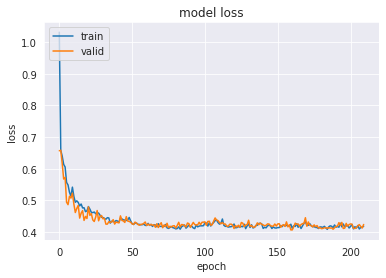

In [26]:
if nas:
    for trial in history: 
        print(trial.summary())
        
    writepath_nas = './results_nas.csv'

    if different_eval_data:
        flat_config = flatten_dict(config_train)
    else:
        flat_config = flatten_dict(config)    

    if not os.path.exists(writepath_nas):
        with open(writepath_nas, 'w+') as text_file:       
            for key in flat_config.keys():
                text_file.write(key)
                text_file.write(';')         

            for hp in history[0].hyperparameters.values.keys():
                text_file.write(hp + ';')    
               
            text_file.write('score')
            
            text_file.write('\n')

    with open(writepath_nas, 'a+') as text_file:  
        for value in flat_config.values():
            text_file.write(str(value))
            text_file.write(';')

        for hp, value in history[0].hyperparameters.values.items():
            text_file.write(str(value) + ';')        

        
        text_file.write(str(history[0].score))
            
        text_file.write('\n')            

        text_file.close()      
        
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

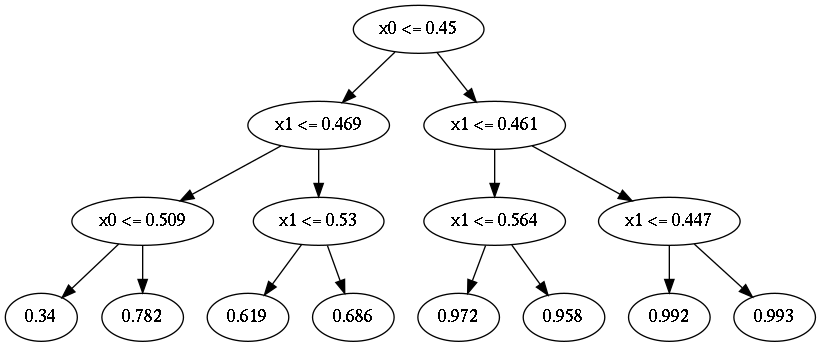

In [27]:
index = 0
if test_size > 0:
    network_parameters = np.array([lambda_net_dataset_test.network_parameters_array[index]])
else:
    network_parameters = np.array([lambda_net_dataset_valid.network_parameters_array[index]])
    
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    network_parameters, network_parameters_flat, _ = autoencode_data(network_parameters, config, encoder_model)    
dt_parameters = model.predict(network_parameters)[0]

if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 513)]        0                                            
__________________________________________________________________________________________________
hidden1_1024 (Dense)            (None, 1024)         526336      input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 1024)         0           hidden1_1024[0][0]               
__________________________________________________________________________________________________
dropout1_0.3 (Dropout)          (None, 1024)         0           activation1_relu[0][0]           
______________________________________________________________________________________________

    Normal: This is useful for looking at means and other linear combinations (e.g. regression coefficients) because of the CLT. Related to that is if something is known to arise due to additive effects of many different small causes then the normal may be a reasonable distribution: for example, many biological measures are the result of multiple genes and multiple environmental factors and therefor are often approximately normal.

    Gamma: Right skewed and useful for things with a natural minimum at 0. Commonly used for elapsed times and some financial variables.

    Exponential: special case of the Gamma. It is memoryless and scales easily.

    Chi-squared (𝜒2): special case of the Gamma. Arises as sum of squared normal variables (so used for variances).

    Beta: Defined between 0 and 1 (but could be transformed to be between other values), useful for proportions or other quantities that must be between 0 and 1.

    Binomial: How many "successes" out of a given number of independent trials with same probability of "success".

    Poisson: Common for counts. Nice properties that if the number of events in a period of time or area follows a Poisson, then the number in twice the time or area still follows the Poisson (with twice the mean): this works for adding Poissons or scaling with values other than 2.

    Note that if events occur over time and the time between occurrences follows an exponential then the number that occur in a time period follows a Poisson.

    Negative Binomial: Counts with minimum 0 (or other value depending on which version) and no upper bound. Conceptually it is the number of "failures" before k "successes". The negative binomial is also a mixture of Poisson variables whose means come from a gamma distribution.

    Geometric: special case for negative binomial where it is the number of "failures" before the 1st "success". If you truncate (round down) an exponential variable to make it discrete, the result is geometric.

In [29]:

mean_train_parameters = np.round(np.mean(lambda_net_dataset_train.network_parameters_array, axis=0), 5)
std_train_parameters = np.round(np.std(lambda_net_dataset_train.network_parameters_array, axis=0), 5)

(inet_evaluation_result_dict_train, 
 inet_evaluation_result_dict_mean_train, 
 dt_distilled_list_train,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_train.network_parameters_array, 
                                                               lambda_net_dataset_train.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='train',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                               encoder_model=encoder_model)


(inet_evaluation_result_dict_valid, 
 inet_evaluation_result_dict_mean_valid, 
 dt_distilled_list_valid,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_valid.network_parameters_array, 
                                                               lambda_net_dataset_valid.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='valid',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                               distances_dict=distances_dict,
                                                               encoder_model=encoder_model)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:   10.5s remaining:  1.6min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   10.6s finished


  0%|          | 0/20 [00:00<?, ?it/s]

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.5s remaining:    4.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.5s finished


  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
%load_ext autoreload
%autoreload 2
#set_loky_pickler('pickle')

In [31]:
#config['i_net']['test_size'] = 100

In [32]:
if evaluate_distribution and test_size > 0:

    (distances_dict, 
     inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_complete_by_distribution_test,
     inet_evaluation_result_dict_mean_test,
     inet_evaluation_result_dict_mean_by_distribution_test,
     inet_evaluation_results_test, 
     dt_inet_list_test, 
     dt_distilled_list_test, 
     data_dict_list_test, 
     normalizer_list_list_test,
     test_network_list,
     model_history_list,
     distribution_parameter_list_list) = distribution_evaluation_interpretation_net_synthetic_data(loss_function, 
                                                                                            metrics,
                                                                                            #model,
                                                                                           config,
                                                                                           identifier='test',
                                                                                           lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array,
                                                                                           mean_train_parameters=mean_train_parameters,
                                                                                           std_train_parameters=std_train_parameters,
                                                                                           distances_dict=distances_dict,
                                                                                           max_distributions_per_class=max_distributions_per_class,#max_distributions_per_class,
                                                                                           flip_percentage=noise_injected_level, #0.1,#
                                                                                           data_noise=data_noise, #0.1,#
                                                                                           #encoder_model=encoder_model,                
                                                                                           distribution_list_generation = ['normal'],#['uniform', 'gamma', 'beta', 'poisson', 'normal'],#['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'],
                                                                                           distribution_list_evaluation = ['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'],#['uniform', 'gamma', 'beta', 'poisson', 'normal'],                                                                                           
                                                                                           random_parameters = random_parameters_distribution, #random_parameters_distribution
                                                                                           verbose=0,
                                                                                           backend='loky',#sequential
                                                                                    )
else:
    (inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_mean_test, 
     dt_distilled_list_test,
     distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_test.network_parameters_array, 
                                                                   lambda_net_dataset_test.X_test_lambda_array,
                                                                   model,
                                                                   config,
                                                                   identifier='test',
                                                                   mean_train_parameters=mean_train_parameters,
                                                                   std_train_parameters=std_train_parameters,
                                                                   network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                                   distances_dict=distances_dict,
                                                                   encoder_model=encoder_model)
    
    print_results_synthetic_evaluation(inet_evaluation_result_dict_mean_train, 
                                       inet_evaluation_result_dict_mean_valid, 
                                       inet_evaluation_result_dict_mean_test, 
                                       distances_dict)    

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:   13.7s remaining:  2.1min
[Parallel(n_jobs=20)]: Done   9 out of  20 | elapsed:   18.8s remaining:   23.0s
[Parallel(n_jobs=20)]: Done  16 out of  20 | elapsed:   28.6s remaining:    7.2s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   46.0s finished


In [33]:
# generate_dataset_from_distributions

In [34]:
distribution_parameter_list_list[0]

[{'normal': {'class_0': {'loc': 0.00022874963468977327,
    'scale': 0.6046651452636795},
   'class_1': {'loc': 0.00022874963468977327, 'scale': 1.6046651452636795},
   'samples_class_0': 2500,
   'feature_weight_0': 1,
   'seed_shuffeling': 0}},
 {'normal': {'class_0': {'loc': 1.0993249557574183,
    'scale': 0.8706447852365538},
   'class_1': {'loc': 2.0, 'scale': 0.8706447852365538},
   'samples_class_0': 2500,
   'feature_weight_0': 1,
   'seed_shuffeling': 0}}]

In [35]:
lambda_net_dataset_valid.distribution_dict_list_list[0]

In [36]:
#np.mean(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy'])

In [37]:
np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy'])

array([0.754, 0.844, 0.628, 0.732, 0.754, 0.68 , 0.72 , 0.384, 0.71 ,
       0.868, 0.862, 0.688, 0.776, 0.716, 0.654, 0.58 , 0.994, 0.834,
       0.736, 0.828])

In [38]:
np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy'])

array([0.84 , 0.722, 0.982, 0.764, 0.836, 0.934, 0.96 , 0.988, 0.892,
       0.84 , 0.804, 0.882, 0.836, 0.98 , 0.424, 0.994, 1.   , 0.928,
       0.97 , 0.746])

In [39]:
print('Median I-Net:', np.median(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']))
print('Median DT Distilled:', np.median(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))


Median I-Net: 0.734
Median DT Distilled: 0.887


In [40]:
complete_distribution_evaluation_results = get_complete_distribution_evaluation_results_dataframe(inet_evaluation_result_dict_mean_by_distribution_test)
complete_distribution_evaluation_results.head(20)

,Acc Distilled Train Data,Acc Distilled Data Random,Acc Distilled,Acc I-Net,Soft BC Distilled Train Data,Soft BC Distilled Data Random,Soft BC Distilled,Soft BC I-Net,BC Distilled Train Data,BC Distilled Data Random,BC Distilled,BC I-Net,F1 Score Distilled Train Data,F1 Score Distilled Data Random,F1 Score Distilled,F1 Score I-Net,Runtime Distilled Train Data,Runtime Distilled Data Random,Runtime Distilled,Runtime I-Net
uniform,0.946,0.962,0.866,0.737,0.530,0.434,0.553,0.643,0.166,0.097,0.313,0.512,0.936,0.972,0.862,0.669,0.007,0.007,0.007,0.092
normal,0.946,0.950,0.946,0.737,0.530,0.515,0.534,0.643,0.166,0.131,0.158,0.512,0.936,0.956,0.935,0.669,0.007,0.007,0.007,0.026
gamma,0.946,0.991,0.704,0.737,0.530,0.424,0.631,0.643,0.166,0.025,6.068,0.512,0.936,0.963,0.581,0.669,0.005,0.005,0.005,0.025
exponential,0.946,0.991,0.725,0.737,0.530,0.425,0.609,0.643,0.166,0.026,2.977,0.512,0.936,0.964,0.614,0.669,0.005,0.005,0.005,0.026
beta,0.946,0.968,0.854,0.737,0.530,0.428,0.556,0.643,0.166,0.079,0.337,0.512,0.936,0.972,0.865,0.669,0.006,0.006,0.006,0.025
binomial,0.946,0.957,0.900,0.737,0.530,0.499,0.566,0.643,0.166,0.100,1.900,0.512,0.936,0.955,0.898,0.669,0.002,0.002,0.002,0.043
poisson,0.946,0.996,0.711,0.737,0.530,0.429,0.660,0.643,0.166,0.011,5.702,0.512,0.936,0.962,0.665,0.669,0.001,0.001,0.001,0.024


In [41]:
network_distances = get_print_network_distances_dataframe(distances_dict)
network_distances.head(20)

,Average Z-Score (Sample to Train Data),Average Distance to Initialization,Average Mean Distance to Train Data,Average Distance to closest Train Data Sample,Average Biggest Distance for Single Neuron,Minimum Biggest Distance for Single Neuron
train,232.202,144.802,194.871,0.000,4.161,0.000
valid,207.840,117.143,176.797,28.668,3.075,0.751
test,335.843,278.656,318.350,124.338,7.349,4.731


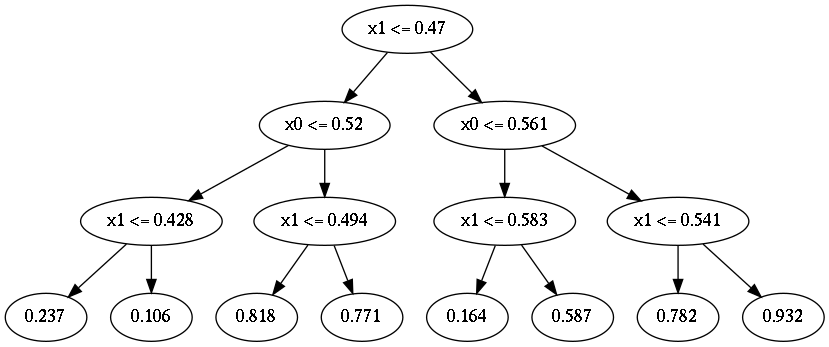

In [42]:
index = 1
dt_parameters = dt_inet_list_test[0][index]

if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

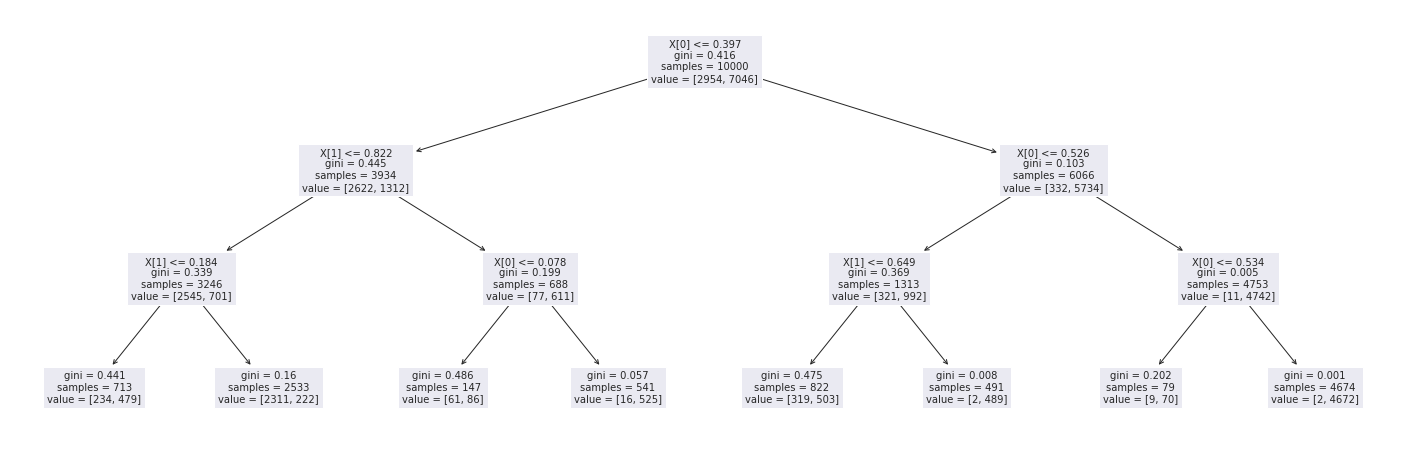

In [43]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(25,8))
    plot_tree(dt_distilled_list_test[0][index][0], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
    image = plt.show()
else:
    image = dt_distilled_list_test[0][index][0].plot_tree()
image

GO
0.0 0.39723990857601166 0.0 -0.2130327671766281
0.0 0.39723990857601166 0.18420714139938354 0.4246281832456589
0.0 0.07839323580265045 0.8218680918216705 0.9216067641973495
0.07839323580265045 0.39723990857601166 0.7434748560190201 0.6027600914239883
0.39723990857601166 0.5259961187839508 -0.39723990857601166 0.12265118956565857
0.39723990857601166 0.5259961187839508 0.2514073997735977 0.4740038812160492
0.5259961187839508 0.5341266393661499 -0.5259961187839508 0.4658733606338501
0.5341266393661499 1.0 -0.5341266393661499 0.0


(0.0, 1.0)

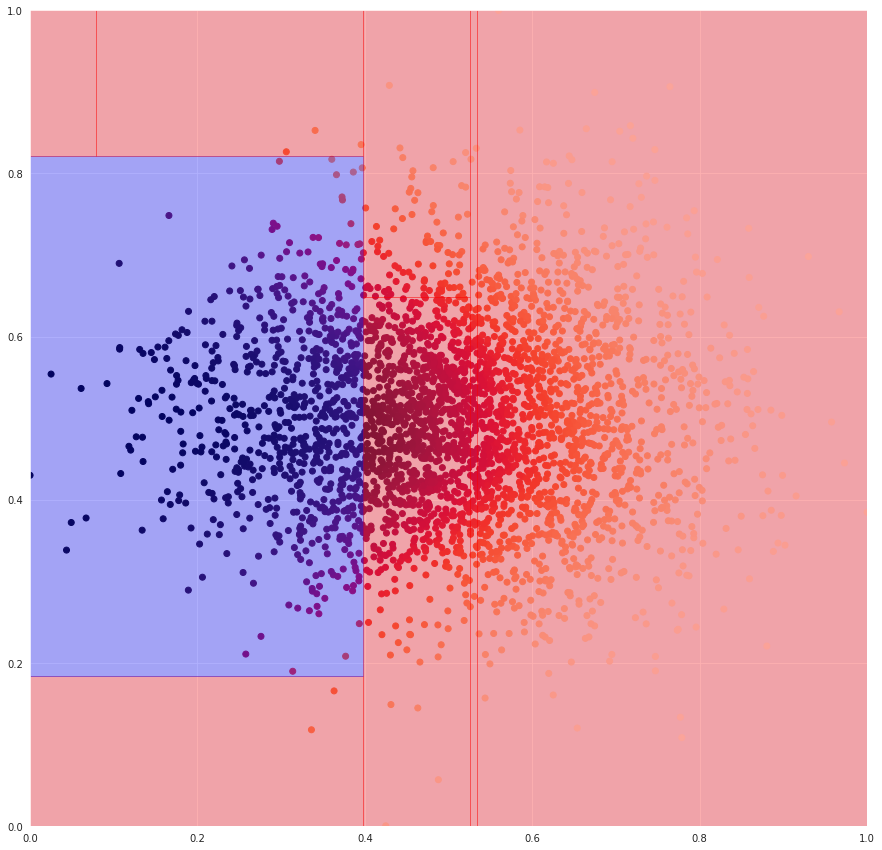

In [44]:
tree = dt_distilled_list_test[0][index][0]

#y_valid_pred = tree.predict(X_valid[:,:2])
#print('Accuracy 2 Features', accuracy_score(y_valid, y_valid_pred))
feature_index = list(np.sort(np.argsort(tree.feature_importances_)[::-1][:2]))
y_train_pred_network = network_parameters_to_network(shaped_network_parameters_to_array(test_network_list[index], config), config).predict(data_dict_list_test[index]['X_train'])
plt.figure(figsize=(15, 15))
plt.scatter(data_dict_list_test[index]['X_train'][:, feature_index[0]], data_dict_list_test[index]['X_train'][:, feature_index[1]], c=y_train_pred_network)

rectangles = decision_areas(tree, [0, 1, 0, 1])
plot_areas(rectangles)
plt.xlim(0, 1)
plt.ylim(0, 1)

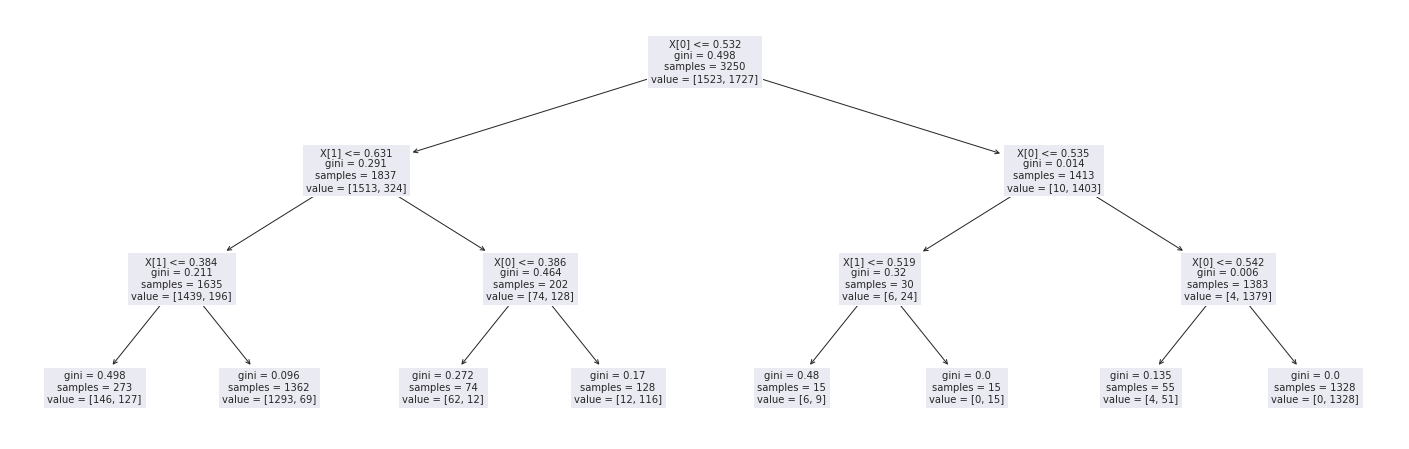

In [45]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(25,8))
    plot_tree(dt_distilled_list_test[0][index][1], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
    image = plt.show()
else:
    image = dt_distilled_list_test[0][index][0].plot_tree()
image

GO
0.0 0.5323614478111267 0.0 -0.14842896163463593
0.0 0.5323614478111267 0.3839324861764908 0.09903332591056824
0.0 0.3856537640094757 0.631394773721695 0.6143462359905243
0.3856537640094757 0.5323614478111267 0.24574100971221924 0.4676385521888733
0.5323614478111267 0.5351009964942932 -0.5323614478111267 -0.016010373830795288
0.5323614478111267 0.5351009964942932 -0.013270825147628784 0.4648990035057068
0.5351009964942932 0.5415197014808655 -0.5351009964942932 0.4584802985191345
0.5415197014808655 1.0 -0.5415197014808655 0.0


(0.0, 1.0)

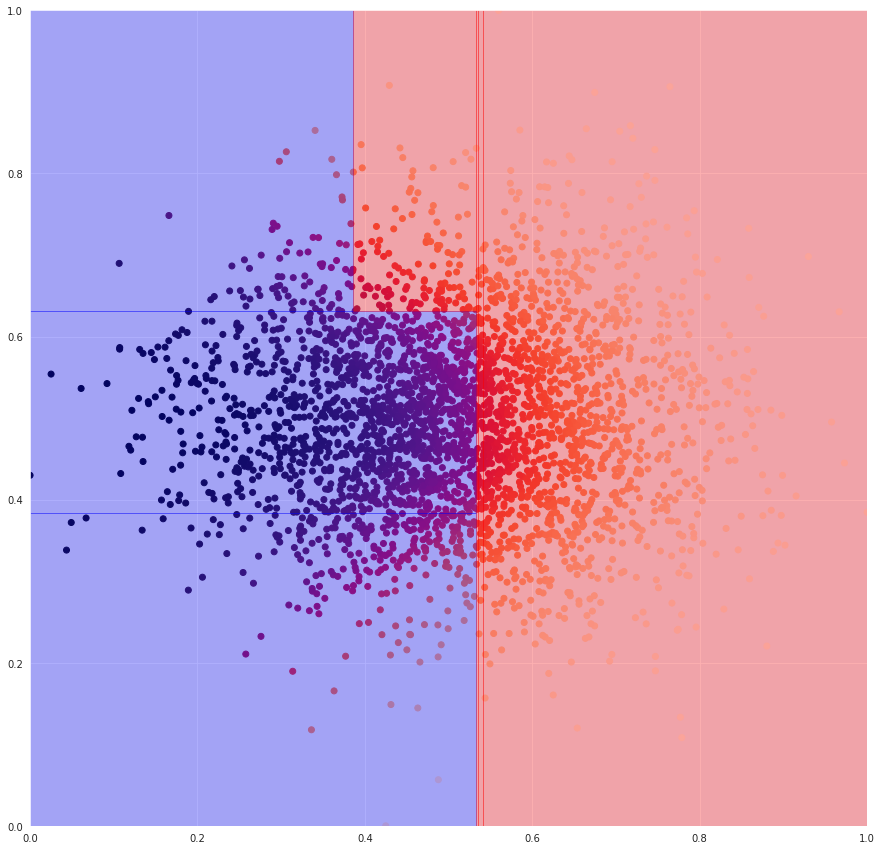

In [46]:
tree = dt_distilled_list_test[0][index][1]

#y_valid_pred = tree.predict(X_valid[:,:2])
#print('Accuracy 2 Features', accuracy_score(y_valid, y_valid_pred))

feature_index = list(np.sort(np.argsort(tree.feature_importances_)[::-1][:2]))
y_train_pred_network = network_parameters_to_network(shaped_network_parameters_to_array(test_network_list[index], config), config).predict(data_dict_list_test[index]['X_train'])
plt.figure(figsize=(15, 15))
plt.scatter(data_dict_list_test[index]['X_train'][:, feature_index[0]], data_dict_list_test[index]['X_train'][:, feature_index[1]], c=y_train_pred_network)

rectangles = decision_areas(tree, [0, 1, 0, 1])
plot_areas(rectangles)
plt.xlim(0, 1)
plt.ylim(0, 1)

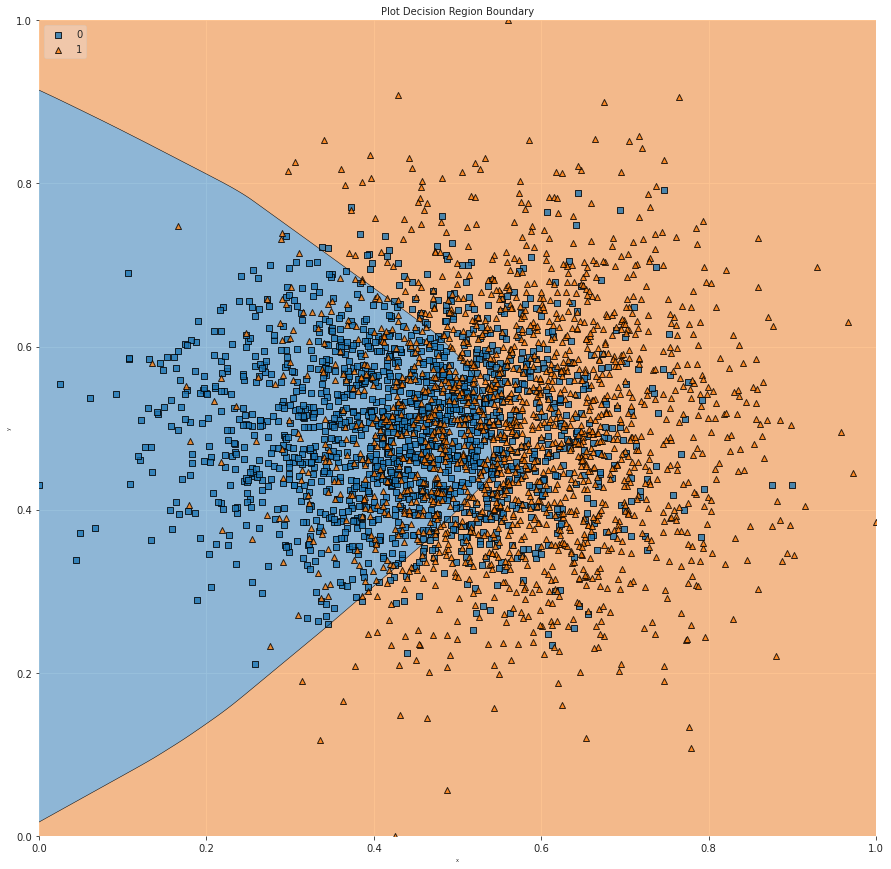

In [47]:
feature_index = list(np.sort(np.argsort(tree.feature_importances_)[::-1][:2]))
filler_features = list(np.sort(np.argsort(tree.feature_importances_)[::-1][2:]))

#plot_decision_regions(X=X_train, y=y_train.ravel(), clf=model, legend=2)

value=0.5
width=0.5

filler_feature_values = {}
filler_feature_ranges = {}
for feature in filler_features:
    filler_feature_values[feature] = value
    filler_feature_ranges[feature] = width

network = network_parameters_to_network(shaped_network_parameters_to_array(test_network_list[index], config), config)

plt.figure(figsize=(15, 15))
plot_decision_regions(X=data_dict_list_test[index]['X_train'],
                      y=data_dict_list_test[index]['y_train'].ravel(), 
                      clf=network,
                      feature_index=feature_index,#[0,1],                        #these one will be plotted  
                      filler_feature_values=filler_feature_values,#{2: value, 3:value},  #these will be ignored
                      filler_feature_ranges=filler_feature_ranges,#{2: width, 3: width}, 
                      legend=2)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("x", size=5)
plt.ylabel("y", size=5)
plt.title('Plot Decision Region Boundary', size=10)
plt.show()

In [48]:
if False:
    number = 6

    X_data, y_data, distribution_parameter_list, normalizer_list = generate_dataset_from_distributions(['uniform'],# ['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'], 
                                          number, 
                                          10000,
                                          distributions_per_class = 1, 
                                          seed=41,
                                          flip_percentage=0,
                                          config=config)

    rand = np.random.RandomState(42)    

    colors_list = ['green','blue','yellow','cyan','magenta','pink']

    fig,ax = plt.subplots(nrows=3, ncols=4,figsize=(25,10))
    plot_index = 0

    for i,(colors, distribution_parameter) in enumerate(zip(colors_list[:number], distribution_parameter_list[:number])):
        print(distribution_parameter)

        x = X_data[:,i][np.where(y_data==0)]
        plt.subplot(3,4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
        plot_index += 1

        x = X_data[:,i][np.where(y_data==1)]
        plt.subplot(3,4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
        plot_index += 1

    fig.subplots_adjust(hspace=0.4,wspace=.3) 
    plt.suptitle('Sampling from Various Distributions',fontsize=20)
    plt.show()


In [49]:
lambda_net_dataset_valid.distribution_dict_list_list[index]

{'dt_scores': {'soft_binary_crossentropy': 0.3138704, 'soft_binary_crossentropy_data_random': 0.36536893, 'binary_crossentropy': 0.000552926030315637, 'binary_crossentropy_data_random': 0.030322609693991392, 'accuracy': 1.0, 'accuracy_data_random': 0.9916, 'f1_score': 1.0, 'f1_score_data_random': 0.9870210135970334, 'runtime': 0.008046388626098633}, 'inet_scores': {'soft_binary_crossentropy': 0.3141986, 'binary_crossentropy': 0.0011635508736828342, 'accuracy': 1.0, 'f1_score': 1.0, 'runtime': 0.025739431381225586}}
Class 0:  626
Class 1:  624


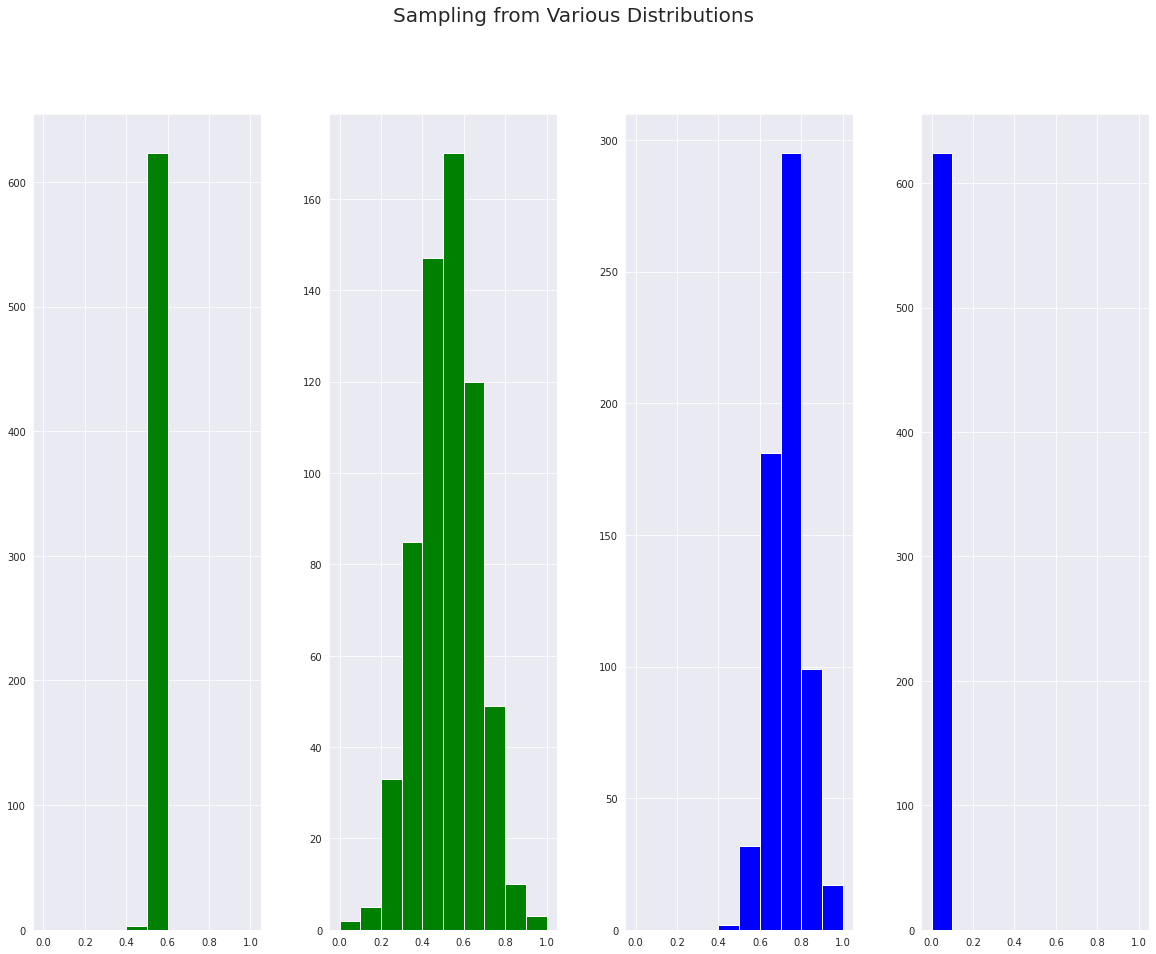

In [50]:
if True:
    #index = 0
    test_network = network_parameters_to_network(lambda_net_dataset_valid.network_parameters_array[index], config, base_model=None)
    distribution_dict = lambda_net_dataset_valid.distribution_dict_list_list[index]

    X_test = lambda_net_dataset_valid.X_test_lambda_array[index]#generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'], categorical_indices=None, distrib=config['evaluation']['random_evaluation_dataset_distribution'])


    distribution_training = 'uniform'

    evaluation_result_dict, results_list, test_network_parameters, dt_inet, dt_distilled_list = evaluate_network_real_world_data(model,
                                                                                                test_network, 
                                                                                                _, 
                                                                                                X_test, 
                                                                                                dataset_size_list=[10000],
                                                                                                config=config,
                                                                                                distribution=distribution_training)


    results_list_extended = results_list[0]

    results_list = results_list_extended
    evaluation_result_dict = results_list

    test_network_parameters = test_network_parameters#[:1]
    dt_inet = dt_inet#[:1]
    dt_distilled_list = dt_distilled_list#[:1]

    print(evaluation_result_dict)
    
    print('Class 0: ', test_network.predict(X_test[np.where(test_network.predict(X_test).ravel()<0.5)]).shape[0])
    print('Class 1: ', test_network.predict(X_test[np.where(test_network.predict(X_test).ravel()>=0.5)]).shape[0])    
    
    ############################################################################################################################################
    ############################################################################################################################################
    
    colors_list = ['green','blue','yellow','cyan','magenta','pink']

    if config['data']['number_of_variables'] > 4:
        fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/4).astype(int), ncols=4,figsize=(20,15))
    else:
        fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/2).astype(int), ncols=2,figsize=(20,15))

    for axis_1 in ax:
        for axis_2 in axis_1:
            axis_2.set_xlim([0, 1])                          
    
    plot_index = 0

    for i in range(X_test.shape[1]):
        try:
            distribution_parameter = distribution_dict[i]
            print(distribution_parameter)
        except:
            pass
        colors = colors_list[i%6]

        x = X_test[:,i][np.where(test_network.predict(X_test).ravel()<=0.5)]
        plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        try:
            plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
        except:
            pass            
        plot_index += 1

        x = X_test[:,i][np.where(test_network.predict(X_test).ravel()>0.5)]
        plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int),4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        try:
            plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
        except:
            pass        
        plot_index += 1

    fig.subplots_adjust(hspace=0.4,wspace=.3) 
    plt.suptitle('Sampling from Various Distributions',fontsize=20)
    plt.show()

{'dt_scores': {'soft_binary_crossentropy': 0.63971806, 'soft_binary_crossentropy_data_random': 0.49427333, 'binary_crossentropy': 0.47220839029808964, 'binary_crossentropy_data_random': 0.2108325618616731, 'accuracy': 0.722, 'accuracy_data_random': 0.914, 'f1_score': 0.8017118402282453, 'f1_score_data_random': 0.9386415525114156, 'runtime': 0.007029294967651367}, 'inet_scores': {'soft_binary_crossentropy': 0.65992266, 'binary_crossentropy': 0.5441038078814745, 'accuracy': 0.732, 'f1_score': 0.7536764705882354, 'runtime': 0.02351999282836914}}
Class 0:  199
Class 1:  301
{'normal': {'class_0': {'loc': 1.0993249557574183, 'scale': 0.8706447852365538}, 'class_1': {'loc': 2.0, 'scale': 0.8706447852365538}, 'samples_class_0': 2500, 'feature_weight_0': 1, 'seed_shuffeling': 1}}
{'normal': {'class_0': {'loc': 1.9453687199297687, 'scale': 1.4296319873487293}, 'class_1': {'loc': 1.9453687199297687, 'scale': 2.0}, 'samples_class_0': 2500, 'feature_weight_0': 1, 'seed_shuffeling': 1}}


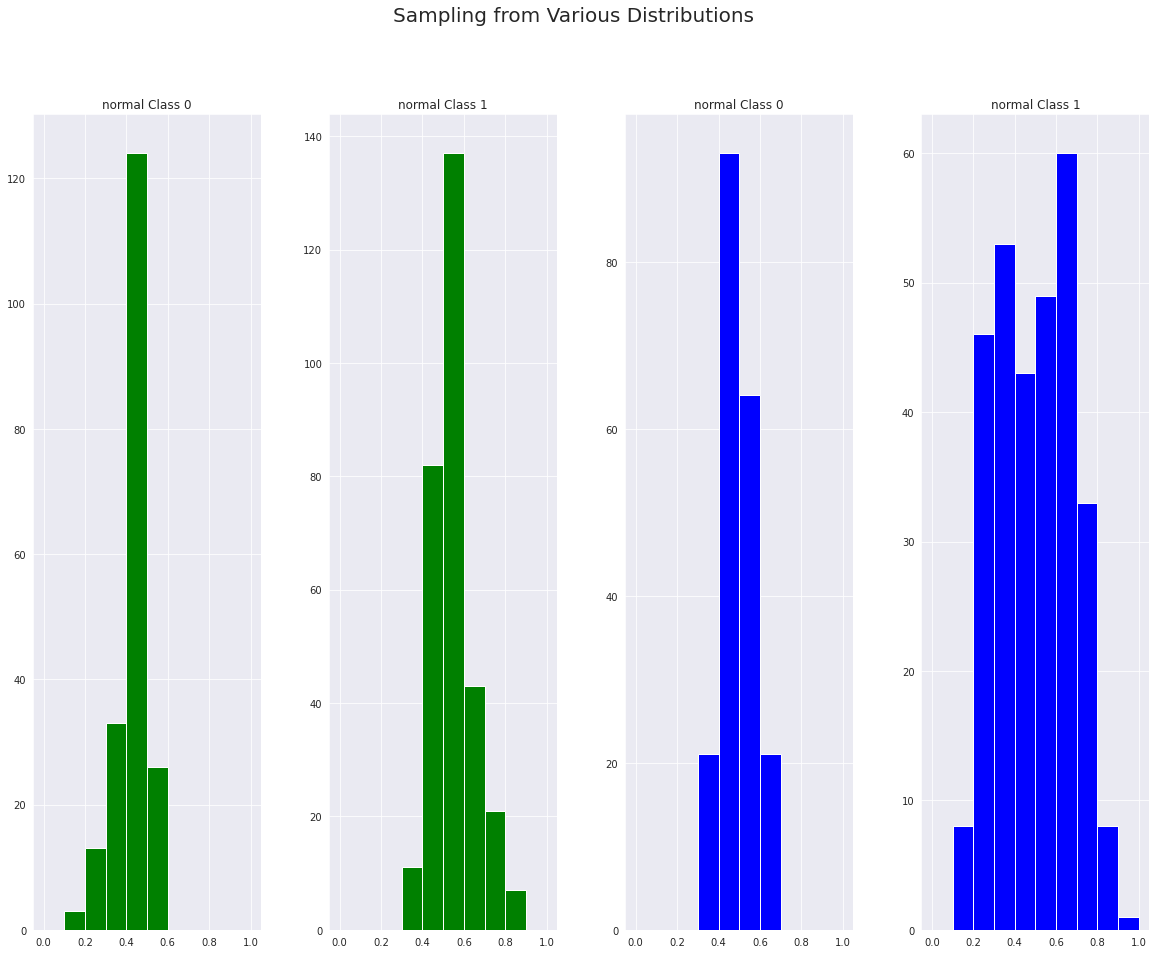

In [51]:
if True:
    #index = 0
    test_network = network_parameters_to_network(shaped_network_parameters_to_array(test_network_list[index], config), config, base_model=None)
    
    distribution_dict = distribution_parameter_list_list[index] 

    X_test = data_dict_list_test[0]['X_test']#generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'], categorical_indices=None, distrib=config['evaluation']['random_evaluation_dataset_distribution'])


    distribution_training = 'uniform'

    evaluation_result_dict, results_list, test_network_parameters, dt_inet, dt_distilled_list = evaluate_network_real_world_data(model,
                                                                                                test_network, 
                                                                                                _, 
                                                                                                X_test, 
                                                                                                dataset_size_list=[10000],
                                                                                                config=config,
                                                                                                distribution=distribution_training)


    results_list_extended = results_list[0]

    results_list = results_list_extended
    evaluation_result_dict = results_list

    test_network_parameters = test_network_parameters#[:1]
    dt_inet = dt_inet#[:1]
    dt_distilled_list = dt_distilled_list#[:1]

    print(evaluation_result_dict)
    
    print('Class 0: ', test_network.predict(X_test[np.where(test_network.predict(X_test).ravel()<0.5)]).shape[0])
    print('Class 1: ', test_network.predict(X_test[np.where(test_network.predict(X_test).ravel()>=0.5)]).shape[0])
        
    ############################################################################################################################################
    ############################################################################################################################################
    
    colors_list = ['green','blue','yellow','cyan','magenta','pink']

    if config['data']['number_of_variables'] > 4:
        fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/4).astype(int), ncols=4,figsize=(20,15))
    else:
        fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/2).astype(int), ncols=2,figsize=(20,15))

    
    for axis_1 in ax:
        for axis_2 in axis_1:
            axis_2.set_xlim([0, 1])                          
    
    plot_index = 0

    for i in range(X_test.shape[1]):
        try:
            distribution_parameter = distribution_dict[i]
            print(distribution_parameter)
        except:
            pass             
        colors = colors_list[i%6]

        x = X_test[:,i][np.where(test_network.predict(X_test).ravel()<=0.5)]
        plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        try:
            plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
        except:
            pass                 
        plot_index += 1

        x = X_test[:,i][np.where(test_network.predict(X_test).ravel()>0.5)]
        plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        try:
            plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
        except:
            pass                 
        plot_index += 1

    fig.subplots_adjust(hspace=0.4,wspace=.3) 
    plt.suptitle('Sampling from Various Distributions',fontsize=20)
    plt.show()    

# REAL DATA EVALUATION

In [52]:
dataset_size_list = [1_000, 10_000, 100_000, 1_000_000, 'TRAIN_DATA']
dataset_size_list_print = []
for size in dataset_size_list:
    if type(size) is int:
        size = size//1000
        size = str(size) + 'k'
        dataset_size_list_print.append(size)
    else:
        dataset_size_list_print.append(size)

In [53]:
#distances_dict = {}
evaluation_result_dict = {}
results_dict = {}
dt_inet_dict = {}
dt_distilled_list_dict = {}
data_dict = {}
normalizer_list_dict = {}

identifier_list = []


## ADULT DATASET

In [54]:
feature_names = [
                 "Age", #0
                 "Workclass",  #1
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Race",  #8
                 "Sex",  #9
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 "Country", #13
                 "capital_gain" #14
                ] 

adult_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=feature_names, index_col=False)


#adult_data['Workclass'][adult_data['Workclass'] != ' Private'] = 'Other'
#adult_data['Race'][adult_data['Race'] != ' White'] = 'Other'

#adult_data.head()

features_select = [
                 "Sex",  #9 
                 "Race",  #8
                 "Workclass",  #1
                 "Age", #0
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 #"Country", #13 
                 "capital_gain"
                  ]

adult_data = adult_data[features_select]

nominal_features_adult = ['Race', 'Workclass', 'Education', "Marital Status", "Occupation", "Relationship"]
ordinal_features_adult = ['Sex']

X_data_adult = adult_data.drop(['capital_gain'], axis = 1)

#y_data_adult = pd.Series(OrdinalEncoder().fit_transform(adult_data['capital_gain'].values.reshape(-1, 1)).flatten(), name='capital_gain')
y_data_adult = ((adult_data['capital_gain'] != ' <=50K') * 1)

In [55]:
config_train_network_adult = deepcopy(config)
#config_train_network_adult['lambda_net']['batch_lambda'] = 32
#config_train_network_adult['lambda_net']['learning_rate_lambda'] = 0.0003
#config_train_network_adult['lambda_net']['dropout_lambda'] = 0.25
#config_train_network_adult['lambda_net']['epochs_lambda'] = 5

Original Data Shape:  (32561, 65)
(19537, 2) (19537,)
(6512, 2) (6512,)
(6512, 2) (6512,)
True Ratio:  0.5


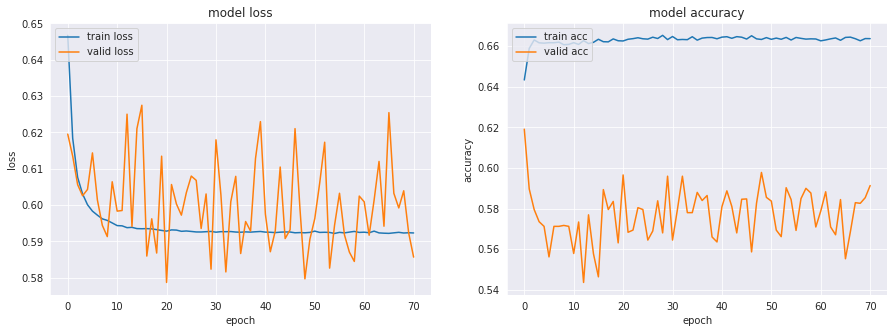

In [56]:
identifier = 'Adult'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_adult, 
                                                                y_data_adult, 
                                                                nominal_features = nominal_features_adult, 
                                                                ordinal_features = ordinal_features_adult,
                                                                config = config,
                                                                config_train_network = config_train_network_adult)

print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict['Adult'], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

## Titanic Dataset

In [57]:
titanic_data = pd.read_csv("./real_world_datasets/Titanic/train.csv")

titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace = True)
titanic_data['Fare'].fillna(titanic_data['Fare'].mean(), inplace = True)
    
titanic_data['Embarked'].fillna('S', inplace = True)

features_select = [
                    #'Cabin', 
                    #'Ticket', 
                    #'Name', 
                    #'PassengerId'    
                    'Sex',    
                    'Embarked',
                    'Pclass',
                    'Age',
                    'SibSp',    
                    'Parch',
                    'Fare',    
                    'Survived',    
                  ]

titanic_data = titanic_data[features_select]

nominal_features_titanic = ['Embarked']#[1, 2, 7]
ordinal_features_titanic = ['Sex']
    
X_data_titanic = titanic_data.drop(['Survived'], axis = 1)
y_data_titanic = titanic_data['Survived']


    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

Original Data Shape:  (891, 9)
(535, 2) (535,)
(178, 2) (178,)
(178, 2) (178,)
True Ratio:  0.5


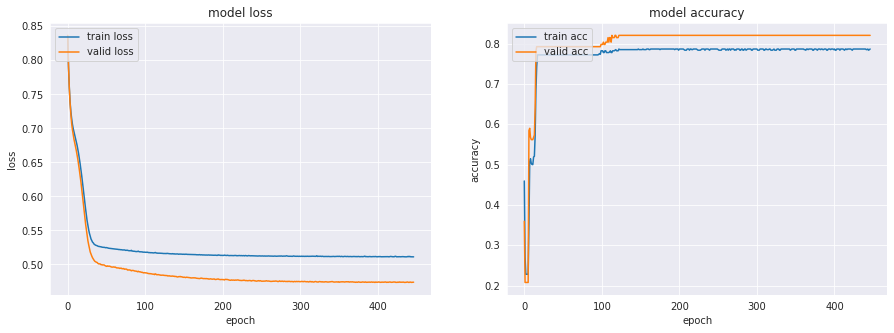

In [58]:
identifier = 'Titanic'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_titanic, 
                                                                y_data_titanic, 
                                                                nominal_features = nominal_features_titanic, 
                                                                ordinal_features = ordinal_features_titanic,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

## Absenteeism at Work Dataset

In [59]:
absenteeism_data = pd.read_csv('real_world_datasets/Absenteeism/absenteeism.csv', delimiter=';')

features_select = [
                           'Disciplinary failure', #CATEGORICAL
                           'Social drinker', #CATEGORICAL
                           'Social smoker', #CATEGORICAL
                           'Transportation expense', 
                           'Distance from Residence to Work',
                           'Service time', 
                           'Age', 
                           'Work load Average/day ', 
                           'Hit target',
                           'Education', 
                           'Son', 
                           'Pet', 
                           'Weight', 
                           'Height', 
                           'Body mass index', 
                           'Absenteeism time in hours'
                        ]

absenteeism_data = absenteeism_data[features_select]

nominal_features_absenteeism = []
ordinal_features_absenteeism = []
    
X_data_absenteeism = absenteeism_data.drop(['Absenteeism time in hours'], axis = 1)
y_data_absenteeism = ((absenteeism_data['Absenteeism time in hours'] > 4) * 1) #absenteeism_data['Absenteeism time in hours']


    3. Month of absence
    4. Day of the week (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6))
    5. Seasons (summer (1), autumn (2), winter (3), spring (4))
    6. Transportation expense
    7. Distance from Residence to Work (kilometers)
    8. Service time
    9. Age
    10. Work load Average/day
    11. Hit target
    12. Disciplinary failure (yes=1; no=0)
    13. Education (high school (1), graduate (2), postgraduate (3), master and doctor (4))
    14. Son (number of children)
    15. Social drinker (yes=1; no=0)
    16. Social smoker (yes=1; no=0)
    17. Pet (number of pet)
    18. Weight
    19. Height
    20. Body mass index
    21. Absenteeism time in hours (target)

Original Data Shape:  (740, 15)
(444, 2) (444,)
(148, 2) (148,)
(148, 2) (148,)
True Ratio:  0.5


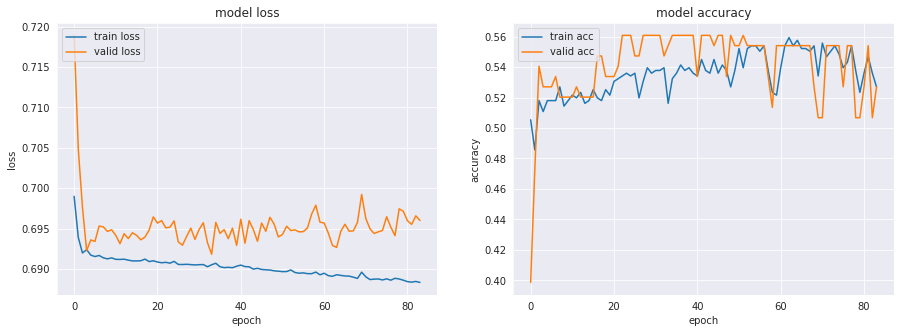

In [60]:
identifier = 'Absenteeism'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_absenteeism, 
                                                                y_data_absenteeism, 
                                                                nominal_features = nominal_features_absenteeism, 
                                                                ordinal_features = ordinal_features_absenteeism,
                                                                config = config,
                                                                config_train_network = None)

print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

## Loan Dataset

In [61]:
loan_data = pd.read_csv('real_world_datasets/Loan/loan-train.csv', delimiter=',')

loan_data['Gender'].fillna(loan_data['Gender'].mode()[0], inplace=True)
loan_data['Dependents'].fillna(loan_data['Dependents'].mode()[0], inplace=True)
loan_data['Married'].fillna(loan_data['Married'].mode()[0], inplace=True)
loan_data['Self_Employed'].fillna(loan_data['Self_Employed'].mode()[0], inplace=True)
loan_data['LoanAmount'].fillna(loan_data['LoanAmount'].mean(), inplace=True)
loan_data['Loan_Amount_Term'].fillna(loan_data['Loan_Amount_Term'].mean(), inplace=True)
loan_data['Credit_History'].fillna(loan_data['Credit_History'].mean(), inplace=True)

features_select = [
                    #'Loan_ID', 
                    'Gender', #
                    'Married', 
                    'Dependents', 
                    'Education',
                    'Self_Employed', 
                    'ApplicantIncome', 
                    'CoapplicantIncome', 
                    'LoanAmount',
                    'Loan_Amount_Term', 
                    'Credit_History', 
                    'Property_Area', 
                    'Loan_Status'
                    ]

loan_data = loan_data[features_select]

loan_data['Dependents'][loan_data['Dependents'] == '3+'] = 4
loan_data['Dependents'] = loan_data['Dependents'].astype(int)

loan_data['Property_Area'][loan_data['Property_Area'] == 'Rural'] = 0
loan_data['Property_Area'][loan_data['Property_Area'] == 'Semiurban'] = 1
loan_data['Property_Area'][loan_data['Property_Area'] == 'Urban'] = 2
loan_data['Property_Area'] = loan_data['Property_Area'].astype(int)

nominal_features_loan = [
                        #'Dependents',
                        #'Property_Area',    
                        ]


ordinal_features_loan = [
                    'Education',
                    'Gender', 
                    'Married', 
                    'Self_Employed',
                   ]
    
X_data_loan = loan_data.drop(['Loan_Status'], axis = 1)
y_data_loan = ((loan_data['Loan_Status'] == 'Y') * 1) 

Original Data Shape:  (614, 11)
(370, 2) (370,)
(122, 2) (122,)
(122, 2) (122,)
True Ratio:  0.5


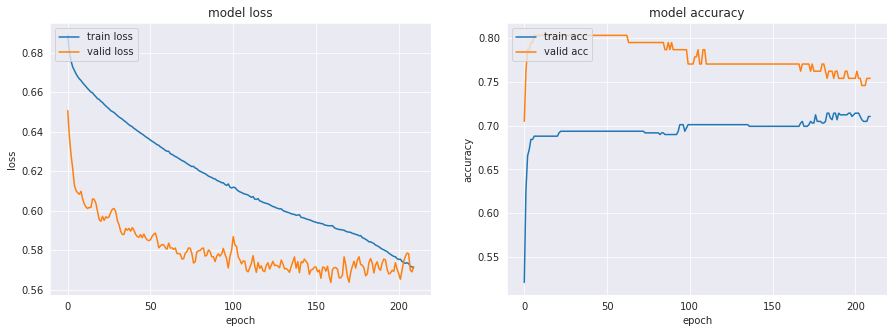

In [62]:
identifier = 'Loan House'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_loan, 
                                                                y_data_loan, 
                                                                nominal_features = nominal_features_loan, 
                                                                ordinal_features = ordinal_features_loan,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

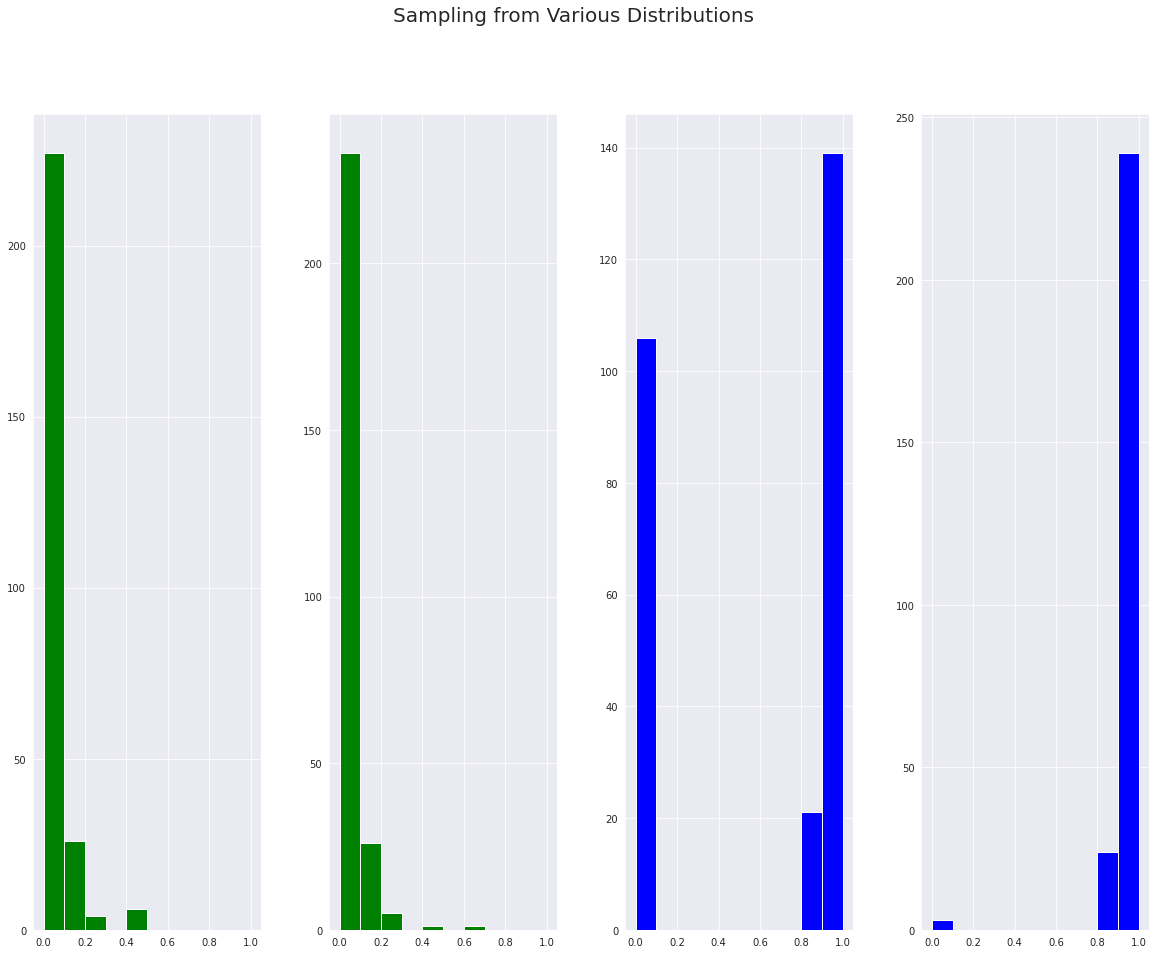

In [63]:
if True:

    X_test = data_dict['Loan House']['X_train'].values#data_dict_list_test[0]['X_test']#generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'], categorical_indices=None, distrib=config['evaluation']['random_evaluation_dataset_distribution'])
    y_test = data_dict['Loan House']['y_train'].values
    
    colors_list = ['green','blue','yellow','cyan','magenta','pink']

    if config['data']['number_of_variables'] > 4:
        fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/4).astype(int), ncols=4,figsize=(20,15))
    else:
        fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/2).astype(int), ncols=2,figsize=(20,15))    
    
    for axis_1 in ax:
        for axis_2 in axis_1:
            axis_2.set_xlim([0, 1])                          
    
    plot_index = 0

    for i in range(X_test.shape[1]):
        #distribution_parameter = distribution_dict[i]
        #print(distribution_parameter)
        colors = colors_list[i%6]

        x = X_test[:,i][np.where(y_test.ravel()<=0.5)]
        plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        #plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
        plot_index += 1

        x = X_test[:,i][np.where(y_test.ravel()>0.5)]
        plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        #plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
        plot_index += 1

    fig.subplots_adjust(hspace=0.4,wspace=.3) 
    plt.suptitle('Sampling from Various Distributions',fontsize=20)
    plt.show()    

## Loan Credit

In [64]:
loan_credit_data = pd.read_csv('real_world_datasets/Credit Loan/train_split.csv', delimiter=',')

loan_credit_data['emp_title'].fillna(loan_credit_data['emp_title'].mode()[0], inplace=True)
loan_credit_data['emp_length'].fillna(loan_credit_data['emp_length'].mode()[0], inplace=True)
#loan_credit_data['desc'].fillna(loan_credit_data['desc'].mode()[0], inplace=True)
loan_credit_data['title'].fillna(loan_credit_data['title'].mode()[0], inplace=True)
#loan_credit_data['mths_since_last_delinq'].fillna(loan_credit_data['mths_since_last_delinq'].mode()[0], inplace=True)
#loan_credit_data['mths_since_last_record'].fillna(loan_credit_data['mths_since_last_record'].mode()[0], inplace=True)
loan_credit_data['revol_util'].fillna(loan_credit_data['revol_util'].mode()[0], inplace=True)
loan_credit_data['collections_12_mths_ex_med'].fillna(loan_credit_data['collections_12_mths_ex_med'].mode()[0], inplace=True)
#loan_credit_data['mths_since_last_major_derog'].fillna(loan_credit_data['mths_since_last_major_derog'].mode()[0], inplace=True)
#loan_credit_data['verification_status_joint'].fillna(loan_credit_data['verification_status_joint'].mode()[0], inplace=True)
loan_credit_data['tot_coll_amt'].fillna(loan_credit_data['tot_coll_amt'].mode()[0], inplace=True)
loan_credit_data['tot_cur_bal'].fillna(loan_credit_data['tot_cur_bal'].mode()[0], inplace=True)
loan_credit_data['total_rev_hi_lim'].fillna(loan_credit_data['total_rev_hi_lim'].mode()[0], inplace=True)


##remove too many null
#'mths_since_last_delinq','mths_since_last_record', 'mths_since_last_major_derog','pymnt_plan','desc', 'verification_status_joint'


features_select = [
                    #'member_id', 
                    'loan_amnt', 
                    'funded_amnt', 
                    'funded_amnt_inv', 
                    'term',
                    #'batch_enrolled',
                    'int_rate', 
                    'grade', 
                    #'sub_grade', 
                    #'emp_title',
                    'emp_length',
                    'home_ownership', 
                    'annual_inc', 
                    'verification_status',
                    #'pymnt_plan', 
                    #'desc', 
                    'purpose', 
                    'title', 
                    #'zip_code', 
                    #'addr_state',
                    'dti', 
                    'delinq_2yrs', 
                    'inq_last_6mths', 
                    #'mths_since_last_delinq',
                    #'mths_since_last_record',
                    'open_acc', 
                    'pub_rec', 
                    'revol_bal',
                    'revol_util', 
                    'total_acc', 
                    'initial_list_status', 
                    'total_rec_int',
                    'total_rec_late_fee', 
                    'recoveries', 
                    'collection_recovery_fee',
                    'collections_12_mths_ex_med', 
                    #'mths_since_last_major_derog',
                    'application_type', 
                    #'verification_status_joint', 
                    'last_week_pay',
                    'acc_now_delinq', 
                    'tot_coll_amt', 
                    'tot_cur_bal', 
                    'total_rev_hi_lim',
                    'loan_status'
                    ]

loan_credit_data = loan_credit_data[features_select]

nominal_features_loan_credit = [

                        ]
ordinal_features_loan_credit = [
                    #'member_id', 
                    'loan_amnt', 
                    'funded_amnt', 
                    'funded_amnt_inv', 
                    'term',
                    #'batch_enrolled',
                    'int_rate', 
                    'grade', 
                    #'sub_grade', 
                    #'emp_title',
                    'emp_length',
                    'home_ownership', 
                    'annual_inc', 
                    'verification_status',
                    #'pymnt_plan', 
                    #'desc', 
                    'purpose', 
                    'title', 
                    #'zip_code', 
                    #'addr_state',
                    'dti', 
                    'delinq_2yrs', 
                    'inq_last_6mths', 
                    #'mths_since_last_delinq',
                    #'mths_since_last_record',
                    'open_acc', 
                    'pub_rec', 
                    'revol_bal',
                    'revol_util', 
                    'total_acc', 
                    'initial_list_status', 
                    'total_rec_int',
                    'total_rec_late_fee', 
                    'recoveries', 
                    'collection_recovery_fee',
                    'collections_12_mths_ex_med', 
                    #'mths_since_last_major_derog',
                    'application_type', 
                    #'verification_status_joint', 
                    'last_week_pay',
                    'acc_now_delinq', 
                    'tot_coll_amt', 
                    'tot_cur_bal', 
                    'total_rev_hi_lim',
                   ]
    
X_data_loan_credit = loan_credit_data.drop(['loan_status'], axis = 1)
y_data_loan_credit = pd.Series(OrdinalEncoder().fit_transform(loan_credit_data['loan_status'].values.reshape(-1, 1)).flatten(), name='loan_status')


Original Data Shape:  (63999, 32)
(38401, 2) (38401,)
(12799, 2) (12799,)
(12799, 2) (12799,)
True Ratio:  0.5


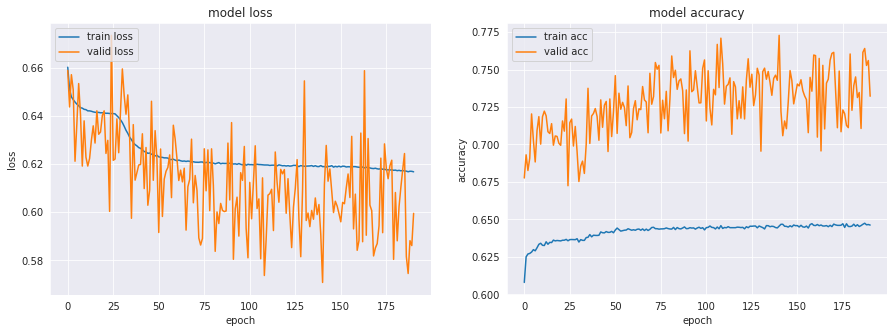

In [65]:
identifier = 'Loan Credit'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_loan_credit, 
                                                                y_data_loan_credit, 
                                                                nominal_features = nominal_features_loan_credit, 
                                                                ordinal_features = ordinal_features_loan_credit,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

# Medical Insurance

In [66]:
medical_insurance_data = pd.read_csv('real_world_datasets/Medical Insurance/insurance.csv', delimiter=',')

features_select = [
                    'age', 
                    'sex', 
                    'bmi', 
                    'children', 
                    'smoker',
                    'region',
                    'charges'
                    ]

medical_insurance_data = medical_insurance_data[features_select]

nominal_features_medical_insurance = [

                        ]
ordinal_features_medical_insurance = [
                    'sex',
                    'region',
                    'smoker'
                   ]

    
X_data_medical_insurance = medical_insurance_data.drop(['charges'], axis = 1)
y_data_medical_insurance = ((medical_insurance_data['charges'] > 10_000) * 1)


print(X_data_medical_insurance.shape)
X_data_medical_insurance.head()


(1338, 6)


,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


Original Data Shape:  (1338, 6)
(804, 2) (804,)
(267, 2) (267,)
(267, 2) (267,)
True Ratio:  0.5


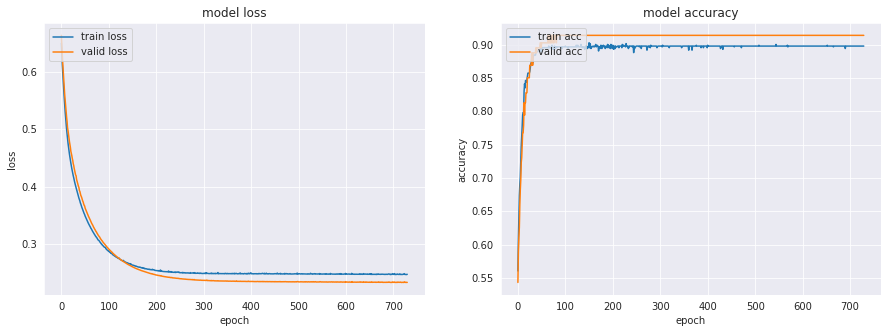

In [67]:
identifier = 'Medical Insurance'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_medical_insurance, 
                                                                y_data_medical_insurance, 
                                                                nominal_features = nominal_features_medical_insurance, 
                                                                ordinal_features = ordinal_features_medical_insurance,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

# Bank Marketing

In [68]:
bank_data = pd.read_csv('real_world_datasets/Bank Marketing/bank-full.csv', delimiter=';') #bank

features_select = [
                    'age',
                    #'job', 
                    'marital', 
                    'education', 
                    'default',
                    'housing',
                    'loan',
                    #'contact',
                    #'day',
                    #'month',
                    'duration',
                    'campaign',
                    'pdays',
                    'previous',
                    'poutcome',
                    'y',
                    ]

bank_data = bank_data[features_select]

nominal_features_bank = [
                        #'job',
                        'education',
                        #'contact',
                        #'day',
                        #'month',
                        'poutcome',
                        ]
ordinal_features_bank = [
                    'marital',
                    'default',
                    'housing',
                    'loan',
                   ]

    
X_data_bank = bank_data.drop(['y'], axis = 1)
y_data_bank = pd.Series(OrdinalEncoder().fit_transform(bank_data['y'].values.reshape(-1, 1)).flatten(), name='y')


Original Data Shape:  (45211, 17)
(27127, 2) (27127,)
(9042, 2) (9042,)
(9042, 2) (9042,)
True Ratio:  0.5


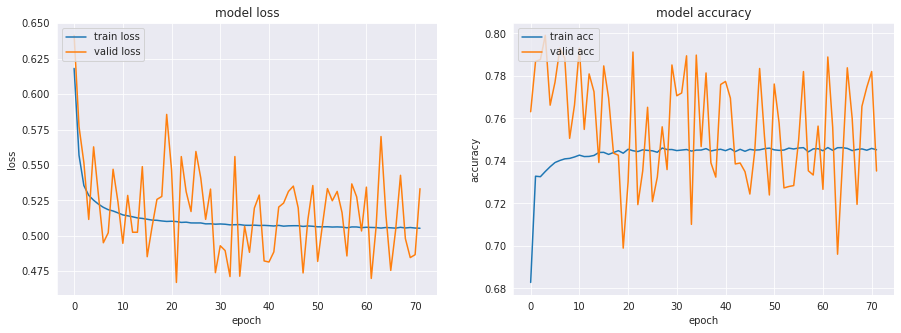

In [69]:
identifier = 'Bank Marketing'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_bank, 
                                                                y_data_bank, 
                                                                nominal_features = nominal_features_bank, 
                                                                ordinal_features = ordinal_features_bank,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

# Brest Cancer Wisconsin

In [70]:
feature_names = [
                'Sample code number',
                'Clump Thickness',
                'Uniformity of Cell Size',
                'Uniformity of Cell Shape',
                'Marginal Adhesion',
                'Single Epithelial Cell Size',
                'Bare Nuclei',
                'Bland Chromatin',
                'Normal Nucleoli',
                'Mitoses',
                'Class',
                ]

bcw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', names=feature_names, index_col=False)

bcw_data['Clump Thickness'][bcw_data['Clump Thickness'] == '?'] = bcw_data['Clump Thickness'].mode()[0]
bcw_data['Uniformity of Cell Size'][bcw_data['Uniformity of Cell Size'] == '?'] = bcw_data['Uniformity of Cell Size'].mode()[0]
bcw_data['Uniformity of Cell Shape'][bcw_data['Uniformity of Cell Shape'] == '?'] = bcw_data['Uniformity of Cell Shape'].mode()[0]
bcw_data['Marginal Adhesion'][bcw_data['Marginal Adhesion'] == '?'] = bcw_data['Marginal Adhesion'].mode()[0]
bcw_data['Single Epithelial Cell Size'][bcw_data['Single Epithelial Cell Size'] == '?'] = bcw_data['Single Epithelial Cell Size'].mode()[0]
bcw_data['Bare Nuclei'][bcw_data['Bare Nuclei'] == '?'] = bcw_data['Bare Nuclei'].mode()[0]
bcw_data['Bland Chromatin'][bcw_data['Bland Chromatin'] == '?'] = bcw_data['Bland Chromatin'].mode()[0]
bcw_data['Normal Nucleoli'][bcw_data['Normal Nucleoli'] == '?'] = bcw_data['Normal Nucleoli'].mode()[0]
bcw_data['Mitoses'][bcw_data['Mitoses'] == '?'] = bcw_data['Mitoses'].mode()[0]

features_select = [
                #'Sample code number',
                'Clump Thickness',
                'Uniformity of Cell Size',
                'Uniformity of Cell Shape',
                'Marginal Adhesion',
                'Single Epithelial Cell Size',
                'Bare Nuclei',
                'Bland Chromatin',
                'Normal Nucleoli',
                'Mitoses',
                'Class',
                    ]

bcw_data = bcw_data[features_select]

nominal_features_bcw = [
                        ]
ordinal_features_bcw = [
                   ]

    
X_data_bcw = bcw_data.drop(['Class'], axis = 1)
y_data_bcw = pd.Series(OrdinalEncoder().fit_transform(bcw_data['Class'].values.reshape(-1, 1)).flatten(), name='Class')


Original Data Shape:  (699, 9)
(421, 2) (421,)
(139, 2) (139,)
(139, 2) (139,)
True Ratio:  0.5


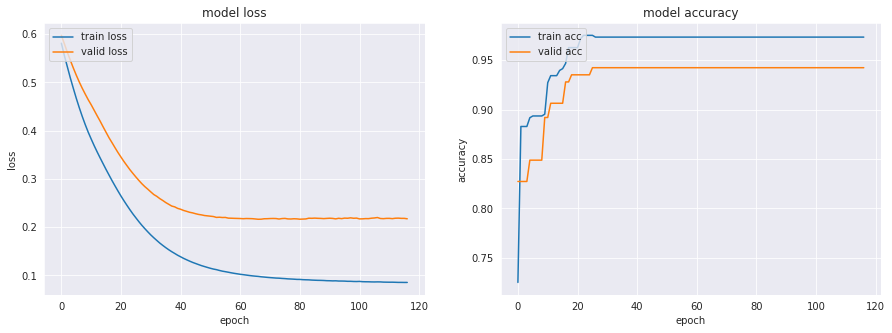

In [71]:
identifier = 'Brest Cancer Wisconsin'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_bcw, 
                                                                y_data_bcw, 
                                                                nominal_features = nominal_features_bcw, 
                                                                ordinal_features = ordinal_features_bcw,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

# Wisconsin Diagnostic Breast Cancer

In [72]:
feature_names = [
                'ID number',
                'Diagnosis',
                'radius',# (mean of distances from center to points on the perimeter)
                'texture',# (standard deviation of gray-scale values)
                'perimeter',
                'area',
                'smoothness',# (local variation in radius lengths)
                'compactness',# (perimeter^2 / area - 1.0)
                'concavity',# (severity of concave portions of the contour)
                'concave points',# (number of concave portions of the contour)
                'symmetry',
                'fractal dimension',# ("coastline approximation" - 1)
                ]
#Wisconsin Diagnostic Breast Cancer
wdbc_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', names=feature_names, index_col=False)

features_select = [
                    #'ID number',
                    'Diagnosis',
                    'radius',# (mean of distances from center to points on the perimeter)
                    'texture',# (standard deviation of gray-scale values)
                    'perimeter',
                    'area',
                    'smoothness',# (local variation in radius lengths)
                    'compactness',# (perimeter^2 / area - 1.0)
                    'concavity',# (severity of concave portions of the contour)
                    'concave points',# (number of concave portions of the contour)
                    'symmetry',
                    'fractal dimension',# ("coastline approximation" - 1)
                    ]

wdbc_data = wdbc_data[features_select]

nominal_features_wdbc = [
                        ]
ordinal_features_wdbc = [
                   ]

    
X_data_wdbc = wdbc_data.drop(['Diagnosis'], axis = 1)
y_data_wdbc= pd.Series(OrdinalEncoder().fit_transform(wdbc_data['Diagnosis'].values.reshape(-1, 1)).flatten(), name='Diagnosis')


Original Data Shape:  (569, 10)
(343, 2) (343,)
(113, 2) (113,)
(113, 2) (113,)
True Ratio:  0.5


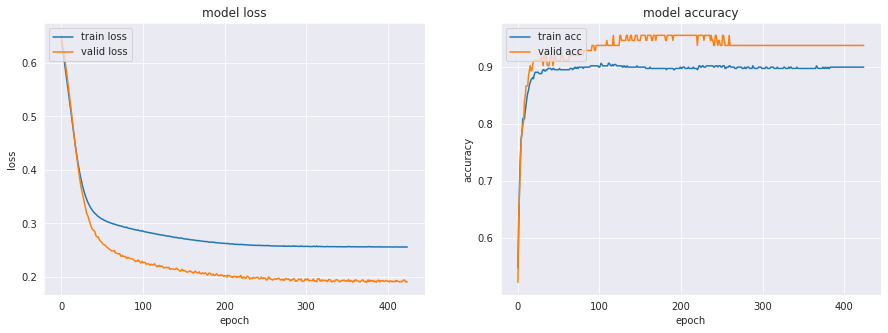

In [73]:
identifier = 'Wisconsin Diagnostic Breast Cancer'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_wdbc, 
                                                                y_data_wdbc, 
                                                                nominal_features = nominal_features_wdbc, 
                                                                ordinal_features = ordinal_features_wdbc,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

# Wisconsin Prognostic Breast Cancer

In [74]:
feature_names = [
                'ID number',
                'Diagnosis',
                'radius',# (mean of distances from center to points on the perimeter)
                'texture',# (standard deviation of gray-scale values)
                'perimeter',
                'area',
                'smoothness',# (local variation in radius lengths)
                'compactness',# (perimeter^2 / area - 1.0)
                'concavity',# (severity of concave portions of the contour)
                'concave points',# (number of concave portions of the contour)
                'symmetry',
                'fractal dimension',# ("coastline approximation" - 1)
                ]
#Wisconsin Prognostic Breast Cancer
wpbc_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wpbc.data', names=feature_names, index_col=False)

features_select = [
                    #'ID number',
                    'Diagnosis',
                    'radius',# (mean of distances from center to points on the perimeter)
                    'texture',# (standard deviation of gray-scale values)
                    'perimeter',
                    'area',
                    'smoothness',# (local variation in radius lengths)
                    'compactness',# (perimeter^2 / area - 1.0)
                    'concavity',# (severity of concave portions of the contour)
                    'concave points',# (number of concave portions of the contour)
                    'symmetry',
                    'fractal dimension',# ("coastline approximation" - 1)
                    ]

wpbc_data = wpbc_data[features_select]

nominal_features_wpbc = [
                        ]
ordinal_features_wpbc = [
                   ]
 
X_data_wpbc = wpbc_data.drop(['Diagnosis'], axis = 1)
y_data_wpbc= pd.Series(OrdinalEncoder().fit_transform(wpbc_data['Diagnosis'].values.reshape(-1, 1)).flatten(), name='Diagnosis')


Original Data Shape:  (198, 10)
(120, 2) (120,)
(39, 2) (39,)
(39, 2) (39,)
True Ratio:  0.5


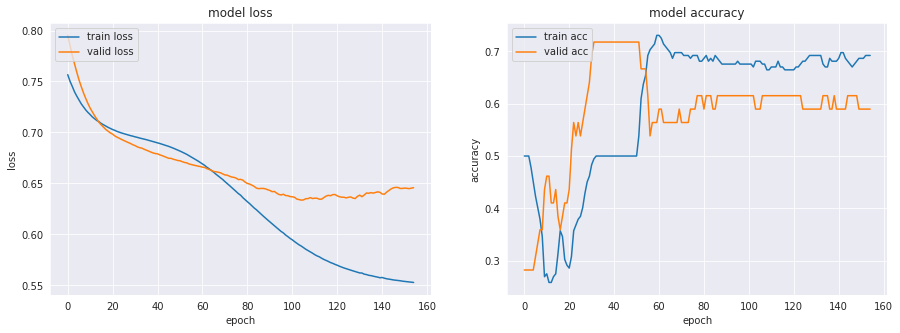

In [75]:
identifier = 'Wisconsin Prognostic Breast Cancer'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_wpbc, 
                                                                y_data_wpbc, 
                                                                nominal_features = nominal_features_wpbc, 
                                                                ordinal_features = ordinal_features_wpbc,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

# Abalone

In [76]:
feature_names = [
                'Sex',#		nominal			M, F, and I (infant)
                'Length',#	continuous	mm	Longest shell measurement
                'Diameter',#	continuous	mm	perpendicular to length
                'Height',#		continuous	mm	with meat in shell
                'Whole weight',#	continuous	grams	whole abalone
                'Shucked weight',#	continuous	grams	weight of meat
                'Viscera weight',#	continuous	grams	gut weight (after bleeding)
                'Shell weight',#	continuous	grams	after being dried
                'Rings',#		integer			+1.5 gives the age in years
                ]

abalone_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', names=feature_names, index_col=False)


features_select = [
                'Sex',#		nominal			M, F, and I (infant)
                'Length',#	continuous	mm	Longest shell measurement
                'Diameter',#	continuous	mm	perpendicular to length
                'Height',#		continuous	mm	with meat in shell
                'Whole weight',#	continuous	grams	whole abalone
                'Shucked weight',#	continuous	grams	weight of meat
                'Viscera weight',#	continuous	grams	gut weight (after bleeding)
                'Shell weight',#	continuous	grams	after being dried
                'Rings',#		integer			+1.5 gives the age in years
                    ]

abalone_data = abalone_data[features_select]

nominal_features_abalone = [
                        'Sex',
                        ]
ordinal_features_abalone = [
                   ]
   
X_data_abalone = abalone_data.drop(['Rings'], axis = 1)
y_data_abalone = ((abalone_data['Rings'] > 10) * 1)
    

Original Data Shape:  (4177, 10)
(2507, 2) (2507,)
(835, 2) (835,)
(835, 2) (835,)
True Ratio:  0.5


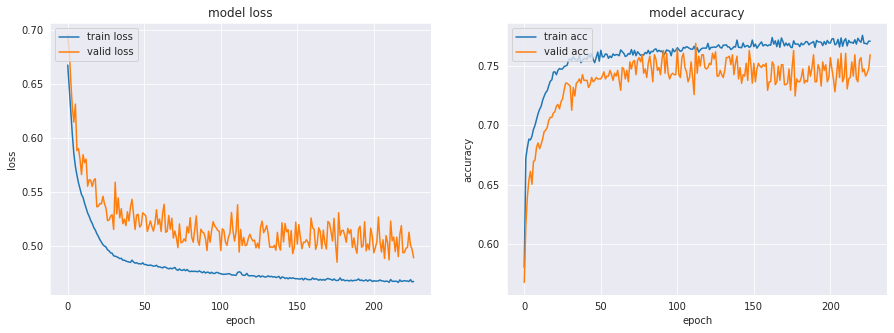

In [77]:
identifier = 'Abalone'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_abalone, 
                                                                y_data_abalone, 
                                                                nominal_features = nominal_features_abalone, 
                                                                ordinal_features = ordinal_features_abalone,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

# Car

In [78]:
feature_names = [
   'buying',#       v-high, high, med, low
   'maint',#        v-high, high, med, low
   'doors',#        2, 3, 4, 5-more
   'persons',#      2, 4, more
   'lug_boot',#     small, med, big
   'safety',#       low, med, high
   'class',#        unacc, acc, good, v-good
                ]

car_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=feature_names, index_col=False)

features_select = [
                   'buying',#       v-high, high, med, low
                   'maint',#        v-high, high, med, low
                   'doors',#        2, 3, 4, 5-more
                   'persons',#      2, 4, more
                   'lug_boot',#     small, med, big
                   'safety',#       low, med, high
                   'class',#        unacc, acc, good, v-good
                    ]

car_data = car_data[features_select]

nominal_features_car = [
                       'buying',#       v-high, high, med, low
                       'maint',#        v-high, high, med, low
                       'doors',#        2, 3, 4, 5-more
                       'persons',#      2, 4, more
                       'lug_boot',#     small, med, big
                       'safety',#       low, med, high
                        ]

ordinal_features_car = [
                   ]


    
X_data_car = car_data.drop(['class'], axis = 1)
y_data_car = ((car_data['class'] != 'unacc') * 1)

Original Data Shape:  (1728, 21)
(1038, 2) (1038,)
(345, 2) (345,)
(345, 2) (345,)
True Ratio:  0.5


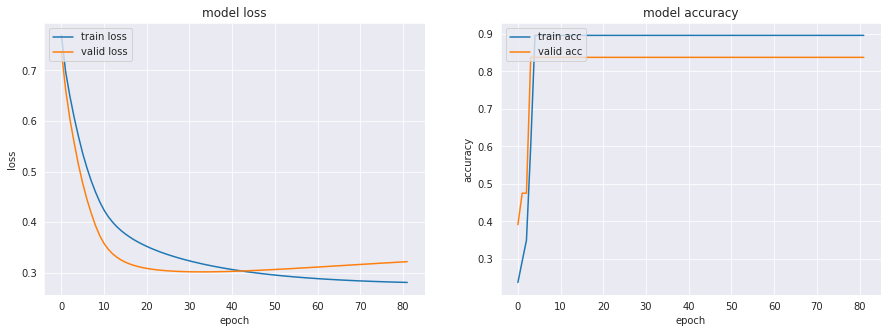

In [79]:
identifier = 'Car'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_car, 
                                                                y_data_car, 
                                                                nominal_features = nominal_features_car, 
                                                                ordinal_features = ordinal_features_car,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

# Plot and Save Results

In [80]:
#print_complete_performance_evaluation_results(results_dict, identifier_list, dataset_size_list, dataset_size=10000)
complete_performance_evaluation_results = get_complete_performance_evaluation_results_dataframe(results_dict, 
                                                                                                identifier_list, 
                                                                                                dataset_size_list,
                                                                                                dataset_size=10000)
complete_performance_evaluation_results.head(20)

,Acc Distilled,Acc I-Net,Soft BC Distilled,Soft BC I-Net,BC Distilled,BC I-Net,F1 Score Distilled,F1 Score I-Net,Runtime Distilled,Runtime I-Net
Adult,0.973,0.553,0.614,0.686,0.101,0.702,0.976,0.389,0.007,0.047
Titanic,1.000,0.949,0.535,0.599,0.050,0.329,1.000,0.931,0.007,0.044
Absenteeism,0.939,0.838,0.751,0.720,0.331,0.415,0.919,0.739,0.007,0.039
Loan House,0.992,0.992,0.649,0.658,0.325,0.337,0.995,0.995,0.007,0.044
Loan Credit,0.959,0.763,0.660,0.740,0.152,0.892,0.928,0.218,0.007,0.044
Medical Insurance,0.891,0.828,0.473,0.503,0.310,0.340,0.879,0.820,0.007,0.046
Bank Marketing,0.921,0.676,0.566,0.689,0.390,0.679,0.880,0.003,0.005,0.045
Brest Cancer Wisconsin,0.993,0.971,0.363,0.526,0.027,0.370,0.988,0.951,0.007,0.038
Wisconsin Diagnostic Breast Cancer,0.982,0.717,0.427,0.616,0.058,0.561,0.980,0.515,0.007,0.046
Wisconsin Prognostic Breast Cancer,0.974,0.974,0.579,0.580,0.057,0.161,0.966,0.963,0.007,0.041


In [81]:
complete_distribution_evaluation_results = get_complete_distribution_evaluation_results_dataframe(inet_evaluation_result_dict_mean_by_distribution_test)
complete_distribution_evaluation_results.head(20)

,Acc Distilled Train Data,Acc Distilled Data Random,Acc Distilled,Acc I-Net,Soft BC Distilled Train Data,Soft BC Distilled Data Random,Soft BC Distilled,Soft BC I-Net,BC Distilled Train Data,BC Distilled Data Random,BC Distilled,BC I-Net,F1 Score Distilled Train Data,F1 Score Distilled Data Random,F1 Score Distilled,F1 Score I-Net,Runtime Distilled Train Data,Runtime Distilled Data Random,Runtime Distilled,Runtime I-Net
uniform,0.946,0.962,0.866,0.737,0.530,0.434,0.553,0.643,0.166,0.097,0.313,0.512,0.936,0.972,0.862,0.669,0.007,0.007,0.007,0.092
normal,0.946,0.950,0.946,0.737,0.530,0.515,0.534,0.643,0.166,0.131,0.158,0.512,0.936,0.956,0.935,0.669,0.007,0.007,0.007,0.026
gamma,0.946,0.991,0.704,0.737,0.530,0.424,0.631,0.643,0.166,0.025,6.068,0.512,0.936,0.963,0.581,0.669,0.005,0.005,0.005,0.025
exponential,0.946,0.991,0.725,0.737,0.530,0.425,0.609,0.643,0.166,0.026,2.977,0.512,0.936,0.964,0.614,0.669,0.005,0.005,0.005,0.026
beta,0.946,0.968,0.854,0.737,0.530,0.428,0.556,0.643,0.166,0.079,0.337,0.512,0.936,0.972,0.865,0.669,0.006,0.006,0.006,0.025
binomial,0.946,0.957,0.900,0.737,0.530,0.499,0.566,0.643,0.166,0.100,1.900,0.512,0.936,0.955,0.898,0.669,0.002,0.002,0.002,0.043
poisson,0.946,0.996,0.711,0.737,0.530,0.429,0.660,0.643,0.166,0.011,5.702,0.512,0.936,0.962,0.665,0.669,0.001,0.001,0.001,0.024


In [82]:
#print_network_distances(distances_dict)
network_distances = get_print_network_distances_dataframe(distances_dict)
network_distances.head(20)

,Average Z-Score (Sample to Train Data),Average Distance to Initialization,Average Mean Distance to Train Data,Average Distance to closest Train Data Sample,Average Biggest Distance for Single Neuron,Minimum Biggest Distance for Single Neuron
train,232.202,144.802,194.871,0.000,4.161,0.000
valid,207.840,117.143,176.797,28.668,3.075,0.751
test,335.843,278.656,318.350,124.338,7.349,4.731
Adult,257.051,103.738,185.973,73.652,3.653,2.185
Titanic,215.302,65.446,156.849,43.172,2.672,0.906
Absenteeism,140.459,14.978,132.403,13.494,2.294,0.164
Loan House,184.520,42.380,146.014,26.012,2.488,0.837
Loan Credit,486.483,234.103,294.495,207.340,12.755,10.457
Medical Insurance,173.623,128.307,164.034,68.250,4.231,1.994
Bank Marketing,383.249,233.120,250.110,91.087,3.882,1.886


In [83]:
writepath_complete = './results_complete.csv'
writepath_summary = './results_summary.csv'

#TODO: ADD COMPLEXITY FOR DTS

if different_eval_data:
    flat_config = flatten_dict(config_train)
else:
    flat_config = flatten_dict(config)    

flat_dict_train = flatten_dict(inet_evaluation_result_dict_train)
flat_dict_valid = flatten_dict(inet_evaluation_result_dict_valid)
if not evaluate_distribution:
    flat_dict_test = flatten_dict(inet_evaluation_result_dict_test)
else:
    flat_dict_test = flatten_dict(inet_evaluation_result_dict_complete_by_distribution_test)

if not os.path.exists(writepath_complete):
    with open(writepath_complete, 'w+') as text_file:       
        for key in flat_config.keys():
            text_file.write(key)
            text_file.write(';')      
        
        number_of_evaluated_networks = np.array(flat_dict_train['inet_scores_binary_crossentropy']).shape[0]
        for key in flat_dict_train.keys():
            #if 'function_values' not in key:
            for i in range(number_of_evaluated_networks):
                text_file.write(key + '_train_' + str(i) + ';')    
                    
        number_of_evaluated_networks = np.array(flat_dict_valid['inet_scores_binary_crossentropy']).shape[0]
        for key in flat_dict_valid.keys():
            #if 'function_values' not in key:
            for i in range(number_of_evaluated_networks):
                text_file.write(key + '_valid_' + str(i) + ';')       
                
        number_of_evaluated_networks = np.array(flat_dict_test[list(flat_dict_test.keys())[0]]).shape[0]
        for key in flat_dict_test.keys():
            #if 'function_values' not in key:
            for i in range(number_of_evaluated_networks):
                text_file.write(key + '_test_' + str(i) + ';')          
        
        text_file.write('\n')
    
with open(writepath_complete, 'a+') as text_file:  
    for value in flat_config.values():
        text_file.write(str(value))
        text_file.write(';')
            
        
    number_of_evaluated_networks = np.array(flat_dict_train['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_train.items():
        #if 'function_values' not in key:
        for score in values:
            text_file.write(str(score) + ';')   

    number_of_evaluated_networks = np.array(flat_dict_valid['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_valid.items():
        #if 'function_values' not in key:
        for score in values:
            text_file.write(str(score) + ';')   

    number_of_evaluated_networks = np.array(flat_dict_test[list(flat_dict_test.keys())[0]]).shape[0]
    for key, values in flat_dict_test.items():
        #if 'function_values' not in key:
        for score in values:
            text_file.write(str(score) + ';')   
                    
    text_file.write('\n')            

    text_file.close()  
    


In [84]:
inet_evaluation_result_dict_mean_train_flat = flatten_dict(inet_evaluation_result_dict_mean_train)
inet_evaluation_result_dict_mean_valid_flat = flatten_dict(inet_evaluation_result_dict_mean_valid)
if not evaluate_distribution:
    inet_evaluation_result_dict_mean_test_flat = flatten_dict(inet_evaluation_result_dict_mean_test)
else:
    inet_evaluation_result_dict_mean_test_flat = flatten_dict(inet_evaluation_result_dict_mean_by_distribution_test)

#identifier_list_synthetic = ['train', 'valid', 'test']
identifier_list_combined = list(flatten_list([identifier_list, ['train', 'valid', 'test']]))

if not os.path.exists(writepath_summary):
    with open(writepath_summary, 'w+') as text_file: 
            
        for key in flat_config.keys():
            text_file.write(key + ';')
         
        for key in inet_evaluation_result_dict_mean_train_flat.keys():
            text_file.write('train_' + key + ';')
        for key in inet_evaluation_result_dict_mean_valid_flat.keys():
            text_file.write('valid_' + key + ';')            
        for key in inet_evaluation_result_dict_mean_test_flat.keys():
            text_file.write('test_' + key + ';')                
        
        for dataset_size in dataset_size_list:
            for identifier in identifier_list:
                results_dict_flat = flatten_dict(results_dict[identifier][-2])
                #del results_dict_flat['function_values_y_test_inet_dt']
                #del results_dict_flat['function_values_y_test_distilled_dt']

                for key in results_dict_flat.keys():
                    text_file.write(key + '_' + identifier + '_' + str(dataset_size) + ';')                                   
         

        for key in distances_dict['train'].keys():
            for identifier in identifier_list_combined:
                text_file.write(key + '_' + identifier + ';') 
        
        text_file.write('\n')
    
with open(writepath_summary, 'a+') as text_file: 
    
    for value in flat_config.values():
        text_file.write(str(value) + ';')
        
    for value in inet_evaluation_result_dict_mean_train_flat.values():
        text_file.write(str(value) + ';')
    for value in inet_evaluation_result_dict_mean_valid_flat.values():
        text_file.write(str(value) + ';')            
    for value in inet_evaluation_result_dict_mean_test_flat.values():
        text_file.write(str(value) + ';')

    for i in range(len(dataset_size_list)):
        for identifier in identifier_list:
            evaluation_result_dict_flat = flatten_dict(evaluation_result_dict[identifier])
            #del evaluation_result_dict_flat['function_values_y_test_inet_dt']
            #del evaluation_result_dict_flat['function_values_y_test_distilled_dt']
            
            for values in evaluation_result_dict_flat.values():
                text_file.write(str(values[i]) + ';')    #values[i]        
     
    for key in distances_dict['train'].keys():
        for identifier in identifier_list_combined:
            text_file.write(str(distances_dict[identifier][key]) + ';')      
    
    text_file.write('\n')

    text_file.close()      

In [85]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

## NEXT DATASET